<div class="alert alert-block alert-success">
    
# FIT5196 Task 2 data transformation in Assessment 2
#### Student Name: Ilya Bessonov, Manh Tung Vu
#### Student ID: 34466029, 30531438

Date: 14/10/2024


Environment: Python 3.10.12

### Introduction

In this task, we are provided with a dataset (`suburb_info.xlsx`) containing key property and demographic information about various suburbs in Melbourne. The primary goal of this task is to prepare the data for building a linear regression model that predicts **median house prices** based on the following five attributes:
- number of houses
- number of units
- population
- percentage of Australian-born residents (aus_born_perc)
- median income.

The dataset includes information on these variables, and we are tasked with exploring whether any data **normalization** or **transformation** is necessary to ensure the data is suitable for linear regression. Specifically, we aim to assess the need for transformations like **standardization**, **min-max normalization**, **log transformation**, **power transformation**, and **Box-Cox transformation**.

### Objective

The objective of this task is to explore the given dataset and determine whether any normalization or transformation is required to meet the assumptions of linear regression, which include:
1. **Scaling the features**: Ensuring that all input variables (features) are on the same scale to improve the efficiency and interpretability of the model.
2. **Linear relationships**: Increasing the linearity between the independent variables and the target variable (median_house_price) for better model performance.

By the end of this task, we will have:
- Investigated the distribution of the selected features.
- Applied appropriate transformations, if necessary.
- Documented the effect of each transformation on the dataset in preparation for linear regression modeling. The ultimate aim is to ensure that the data is well-prepared for the subsequent modeling stage, maximizing the chances of creating a robust and interpretable predictive model.|

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
from scipy.stats import boxcox
from scipy import stats
from sklearn.preprocessing import RobustScaler

In [3]:
# Load housing data frame
housing = pd.read_excel('/content/drive/Shareddrives/FIT5196_S2_2024/GroupAssessment2/suburb_info.xlsx')
housing.head()

,suburb,number_of_houses,number_of_units,municipality,aus_born_perc,median_income,median_house_price,population
0,ABBOTSFORD,2304,4706,Yarra,68%,"$1,797","$1,299,400",4025
1,ABERFELDIE,1410,453,Moonee Valley,81%,"$1,571","$1,926,600",22442
2,ALBANVALE,1897,138,Brimbank,46%,$907,"$594,200",54005
3,ALBION,1389,1392,Brimbank,52%,$929,"$739,100",30677
4,ALPHINGTON,1729,1099,Darebin,73%,"$1,538","$1,729,600",9227


In [4]:
housing_original = housing.copy()

## Quick EDA

In [5]:
housing.shape

(202, 8)

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   suburb              202 non-null    object
 1   number_of_houses    202 non-null    int64 
 2   number_of_units     202 non-null    int64 
 3   municipality        202 non-null    object
 4   aus_born_perc       202 non-null    object
 5   median_income       202 non-null    object
 6   median_house_price  202 non-null    object
 7   population          202 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 12.8+ KB


Many columns are not in numeric (int or float) datatype. We will typecast these columns.

In [7]:
housing.isna().sum()

,0
suburb,0
number_of_houses,0
number_of_units,0
municipality,0
aus_born_perc,0
median_income,0
median_house_price,0
population,0


# Typecast aus_born_perc

In [8]:
def remove_perc(percent):
    """
    Removes the percentage sign from a string and returns the number as an integer.

    Args:
        percent (str): A string containing a percentage value (e.g., '45%').

    Returns:
        int: The numeric value as an integer (e.g., 45).
    """
    # Extract the numeric portion from the percentage string and convert it to an integer.
    number = re.search(r'([\d\.\,]+)\%', percent).group(1)
    return int(number)


In [9]:
# Test
print(remove_perc('51%'))
print(type(remove_perc('100%')))


51
<class 'int'>


In [10]:
# Apply remove_perc function to 'aus_born_perc'
housing['aus_born_perc'] = housing['aus_born_perc'].apply(remove_perc)


In [11]:
housing.describe()

,number_of_houses,number_of_units,aus_born_perc,population
count,202.000000,202.000000,202.000000,202.000000
mean,4155.767327,2480.410891,68.366337,18659.311881
std,3400.864988,3132.684712,10.761293,9604.187282
min,283.000000,60.000000,36.000000,170.000000
25%,1973.500000,620.500000,62.000000,12063.000000
50%,3256.500000,1603.000000,70.000000,17583.000000
75%,5518.500000,3089.000000,77.000000,24045.000000
max,23338.000000,24380.000000,88.000000,54005.000000


In [12]:
housing['aus_born_perc'].head(3)

,aus_born_perc
0,68
1,81
2,46


# Typecast median_income

In [13]:
def extract_price_number_v2(price_string):
    """
    Converts a price string (containing a dollar sign and/or commas) into an integer.

    Args:
        price_string (str): A string representing a price (e.g., '$1,200') or a numeric value.

    Returns:
        int: The numeric price value as an integer after removing any dollar signs and commas.
    """
    # Convert the input to a string, if it's not already, and remove commas and the dollar sign.
    price_string = str(price_string).replace(',', '').replace('$', '')

    # Convert the cleaned string to an integer and return it.
    return int(price_string)


In [14]:
# Test
print(extract_price_number_v2('$123,456'))
print(type(extract_price_number_v2('$123,456')))
print(extract_price_number_v2('123,456'))
print(type(extract_price_number_v2('123,456')))

123456
<class 'int'>
123456
<class 'int'>


In [15]:
# Apply 'extract_price_number' function to 'median_income'
housing['median_income'] = housing['median_income'].apply(extract_price_number_v2)
housing['median_income'].head(3)

,median_income
0,1797
1,1571
2,907


# Typecast median_house_price

In [16]:
# Apply 'extract_price_number' function to 'median_house_price'
housing['median_house_price'] = housing['median_house_price'].apply(extract_price_number_v2)
housing['median_house_price'].head(3)

,median_house_price
0,1299400
1,1926600
2,594200


In [17]:
housing.describe()

,number_of_houses,number_of_units,aus_born_perc,median_income,median_house_price,population
count,202.000000,202.000000,202.000000,202.000000,2.020000e+02,202.000000
mean,4155.767327,2480.410891,68.366337,1387.935644,1.218817e+06,18659.311881
std,3400.864988,3132.684712,10.761293,317.841321,4.716807e+05,9604.187282
min,283.000000,60.000000,36.000000,633.000000,5.072000e+05,170.000000
25%,1973.500000,620.500000,62.000000,1182.250000,8.706750e+05,12063.000000
50%,3256.500000,1603.000000,70.000000,1393.000000,1.134500e+06,17583.000000
75%,5518.500000,3089.000000,77.000000,1560.000000,1.467550e+06,24045.000000
max,23338.000000,24380.000000,88.000000,2352.000000,2.875800e+06,54005.000000


In [18]:
# Explore 'suburb' and 'municipality' columns
print(len(housing['suburb'].unique()))
print(len(housing['municipality'].unique()))
print(housing['municipality'].unique())

202
28
['Yarra' 'Moonee Valley' 'Brimbank' 'Darebin' 'Hobsons Bay' 'Stonnington'
 'Monash' 'Kingston' 'Hume' 'Port Phillip' 'Boroondara' 'Knox' 'Maroondah'
 'Bayside' 'Banyule' 'Glen Eira' 'Whitehorse' 'Maribyrnong' 'Moreland'
 'Manningham' 'Whittlesea' 'Melton' 'Melbourne' 'Greater Dandenong'
 'Nillumbik' 'Casey' 'Yarra Ranges' 'Wyndham']


In [19]:
# Number of observations for every municipality
municipality_counts = housing.groupby('municipality')['suburb'].count()
print(municipality_counts)


municipality
Banyule              15
Bayside               7
Boroondara            8
Brimbank             13
Casey                 3
Darebin               7
Glen Eira            10
Greater Dandenong     5
Hobsons Bay           9
Hume                 10
Kingston             11
Knox                  7
Manningham            5
Maribyrnong           7
Maroondah             9
Melbourne             4
Melton                3
Monash                9
Moonee Valley         8
Moreland             10
Nillumbik             5
Port Phillip          3
Stonnington           7
Whitehorse            8
Whittlesea            5
Wyndham               4
Yarra                 6
Yarra Ranges          4
Name: suburb, dtype: int64


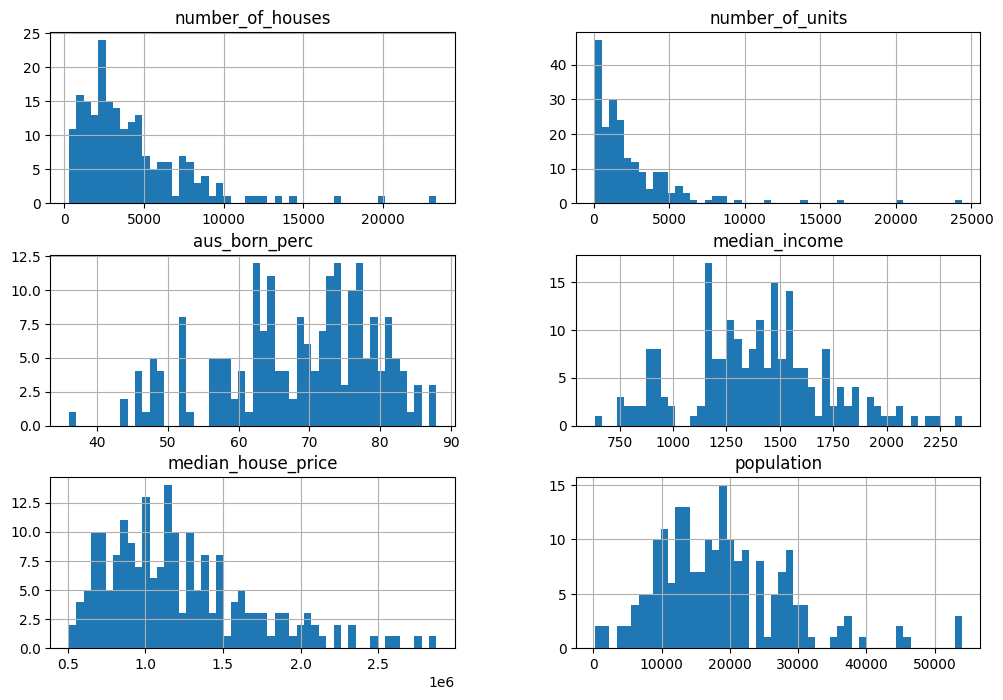

In [20]:
# Create a histogram for each numeric features
housing.hist(bins = 50, figsize = (12,8))
plt.show()

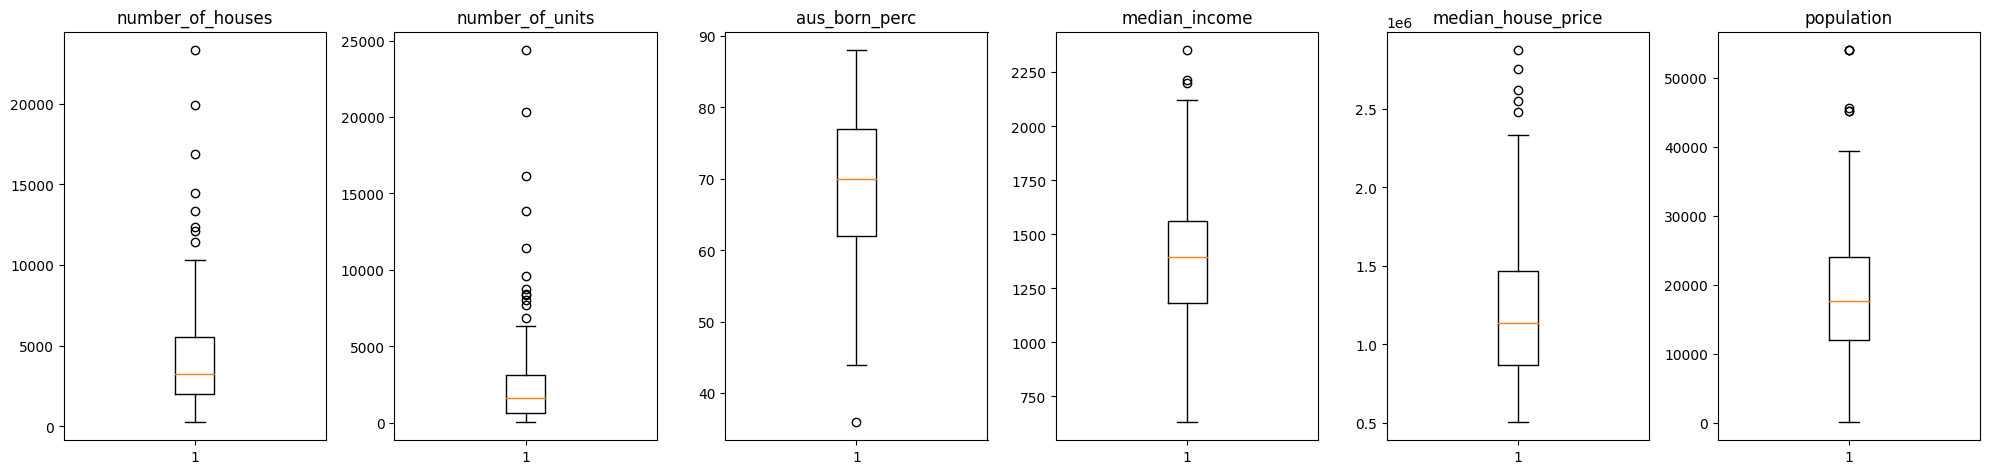

In [21]:
numerical_features = housing.select_dtypes(include=np.number)

# Create subplots for each numerical feature
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_features.columns), figsize=(20, 5))

for i, column in enumerate(numerical_features.columns):
  axes[i].boxplot(numerical_features[column])
  axes[i].set_title(column)

plt.tight_layout()
plt.show()


# Transformation

In [22]:
housing.columns

Index(['suburb', 'number_of_houses', 'number_of_units', 'municipality',
       'aus_born_perc', 'median_income', 'median_house_price', 'population'],
      dtype='object')

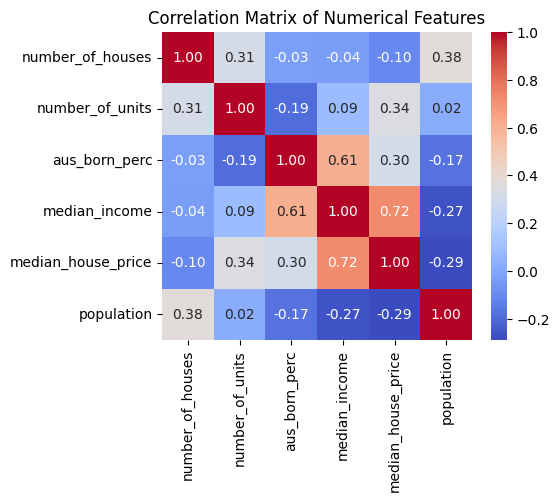

In [23]:

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Need to work on:
1. population
2. aus_born_perc
3. number_of_houses
4. number_of_unit
5. median_income

In [24]:
# @title Standardize function
def standardize_column(df, column_name):
    """
    Standardizes the values in a specified column of a DataFrame,
    plots a histogram and Q-Q plot, and computes kurtosis, skewness,
    and Shapiro-Wilk test statistics.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to standardize.

    Returns:
    pd.Series: A Series containing the standardized values of the specified column.
    """
    # Calculate mean and standard deviation
    mean = df[column_name].mean()
    std_dev = df[column_name].std()

    # Standardize the column
    standardized_values = (df[column_name] - mean) / std_dev
    df[f'{column_name}_standardized'] = standardized_values

    # Plot histogram and Q-Q plot
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(standardized_values, bins=30, edgecolor='black')
    plt.xlabel(f'Standardized {column_name}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Standardized {column_name}')

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(standardized_values, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of Standardized {column_name}')

    plt.tight_layout()
    plt.show()

    # Calculate kurtosis and skewness
    kurtosis = stats.kurtosis(standardized_values)
    skewness = stats.skew(standardized_values)

    # Perform Shapiro-Wilk test
    shapiro_stat, shapiro_p_value = stats.shapiro(standardized_values)

    # Print statistical results
    print(f"Kurtosis of {column_name}: {kurtosis}")
    print(f"Skewness of {column_name}: {skewness}")
    print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}, p-value: {shapiro_p_value}")

    if shapiro_p_value > 0.05:
        print("The transformed data is normally distributed (fail to reject H0).")
    else:
        print("The transformed data is not normally distributed (reject H0).")

    return None

In [25]:
# @title Robust scaling and plot function
def robust_scale_and_plot(df, column_name, target_variable='median_house_price'):
    """
    Performs robust scaling on a specified column of a DataFrame,
    plots the transformed data, and returns the transformed values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to transform.
    target_variable (str): The name of the target variable for correlation analysis.

    Returns:
    pd.Series: The transformed values of the specified column.
    """
    test_stat_dict = {}
    # Initialize the RobustScaler
    scaler = RobustScaler()

    # Reshape and fit-transform the data
    transformed_values = scaler.fit_transform(df[[column_name]])

    # Add transformed values to the DataFrame
    df[f'{column_name}_robust'] = transformed_values

    # Plot the transformed data
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(df[f'{column_name}_robust'], bins=30, edgecolor='black')
    plt.xlabel(f'Robustly Scaled {column_name}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Robustly Scaled {column_name}')

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[f'{column_name}_robust'], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of Robustly Scaled {column_name}')

    plt.tight_layout()
    plt.show()

    # Calculate kurtosis and skewness
    kurtosis_value = stats.kurtosis(df[f'{column_name}_robust'])
    skewness_value = stats.skew(df[f'{column_name}_robust'])

    # Perform the Shapiro-Wilk test
    shapiro_stat, shapiro_p_value = stats.shapiro(df[f'{column_name}_robust'])
    test_stat_dict['shapiro_stat'] = shapiro_stat
    test_stat_dict['shapiro_p_value'] = shapiro_p_value


    # Print the statistical results
    print("Statistical Results:")
    print(f"Kurtosis: {kurtosis_value:.4f}")
    print(f"Skewness: {skewness_value:.4f}")
    print(f"Shapiro-Wilk Test Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p_value:.4f}")

    if shapiro_p_value > 0.05:
        print("The robustly scaled data is normally distributed (fail to reject H0).")
    else:
        print("The robustly scaled data is not normally distributed (reject H0).")

    return test_stat_dict

In [26]:
# @title Root transform and plot function
def root_transform_and_plot(df, column_name, target_variable='median_house_price'):
    """
    Performs square root transformation on a specified column of a DataFrame,
    plots the transformed data, and returns the transformed values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to transform.
    target_variable (str): The name of the target variable for correlation analysis.

    Returns:
    pd.Series: The transformed values of the specified column.
    """
    test_stat_dict = {}
    # Perform square root transformation
    transformed_values = np.sqrt(df[column_name])

    # Add transformed values to the DataFrame
    df[f'{column_name}_sqrt'] = transformed_values

    # Plot the transformed data
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(df[f'{column_name}_sqrt'], bins=30, edgecolor='black')
    plt.xlabel(f'Transformed {column_name} (Square Root)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Transformed {column_name} (Square Root)')

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[f'{column_name}_sqrt'], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of Transformed {column_name} (Square Root)')

    plt.tight_layout()
    plt.show()

    # Calculate kurtosis and skewness
    kurtosis_value = stats.kurtosis(df[f'{column_name}_sqrt'])
    skewness_value = stats.skew(df[f'{column_name}_sqrt'])

    # Perform the Shapiro-Wilk test
    shapiro_stat, shapiro_p_value = stats.shapiro(df[f'{column_name}_sqrt'])
    test_stat_dict['shapiro_stat'] = shapiro_stat
    test_stat_dict['shapiro_p_value'] = shapiro_p_value

    # Print the statistical results
    print("Statistical Results:")
    print(f"Kurtosis: {kurtosis_value:.4f}")
    print(f"Skewness: {skewness_value:.4f}")
    print(f"Shapiro-Wilk Test Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p_value:.4f}")

    if shapiro_p_value > 0.05:
        print("The transformed data is normally distributed (fail to reject H0).")
    else:
        print("The transformed data is not normally distributed (reject H0).")

    return test_stat_dict

In [27]:
# @title Log transform and plot function
def log_transform_and_plot(df, column_name):
    """
    Performs log transformation on a specified column of a DataFrame,
    plots the transformed data, and returns the transformed values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to transform.

    Returns:
    pd.Series: The transformed values of the specified column.
    """
    test_stat_dict = {}
    # Check for non-positive values, since log(0) and log(negative) are undefined
    if (df[column_name] <= 0).any():
        raise ValueError(f"Log transformation is not defined for non-positive values in column '{column_name}'.")

    # Perform log transformation
    transformed_values = np.log(df[column_name])

    # Add transformed values to the DataFrame
    df[f'{column_name}_log'] = transformed_values

    # Plot the transformed data
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(df[f'{column_name}_log'], bins=30, edgecolor='black')
    plt.xlabel(f'Transformed {column_name} (Log)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Transformed {column_name} (Log)')

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[f'{column_name}_log'], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of Transformed {column_name} (Log)')

    plt.tight_layout()
    plt.show()

    # Calculate kurtosis and skewness
    kurtosis_value = stats.kurtosis(df[f'{column_name}_log'])
    skewness_value = stats.skew(df[f'{column_name}_log'])

    # Perform the Shapiro-Wilk test
    shapiro_stat, shapiro_p_value = stats.shapiro(df[f'{column_name}_log'])
    test_stat_dict['shapiro_stat'] = shapiro_stat
    test_stat_dict['shapiro_p_value'] = shapiro_p_value


    # Print the statistical results
    print("Statistical Results:")
    print(f"Kurtosis: {kurtosis_value:.4f}")
    print(f"Skewness: {skewness_value:.4f}")
    print(f"Shapiro-Wilk Test Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p_value:.4f}")

    if shapiro_p_value > 0.05:
        print("The transformed data is normally distributed (fail to reject H0).")
    else:
        print("The transformed data is not normally distributed (reject H0).")

    return test_stat_dict


In [28]:
# @title Boxcox transform and plot function
def boxcox_transform_and_plot(df, column_name):
    """
    Performs Box-Cox transformation on a specified column of a DataFrame,
    plots the transformed data, and returns the transformed values and lambda.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to transform.

    Returns:
    tuple: A tuple containing:
        - pd.Series: The transformed values of the specified column.
        - float: The lambda value used for the Box-Cox transformation.
    """
    test_stat_dict = {}
    # Perform Box-Cox transformation
    transformed_values, lambda_val = boxcox(df[column_name])

    # Add transformed values to the DataFrame
    df[f'{column_name}_bc'] = transformed_values

    # Plot the transformed data
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(df[f'{column_name}_bc'], bins=30, edgecolor='black')
    plt.xlabel(f'Transformed {column_name} (Box-Cox)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Transformed {column_name} (Box-Cox)')

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[f'{column_name}_bc'], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of Transformed {column_name} (Box-Cox)')

    plt.tight_layout()
    plt.show()

    print(f"Lambda value for Box-Cox transformation: {lambda_val}")

    # Calculate kurtosis and skewness
    kurtosis_value = stats.kurtosis(df[f'{column_name}_bc'])
    skewness_value = stats.skew(df[f'{column_name}_bc'])

    # Perform the Shapiro-Wilk test
    shapiro_stat, shapiro_p_value = stats.shapiro(df[f'{column_name}_bc'])
    test_stat_dict['shapiro_stat'] = shapiro_stat
    test_stat_dict['shapiro_p_value'] = shapiro_p_value


    # Print the statistical results
    print("Statistical Results:")
    print(f"Kurtosis: {kurtosis_value:.4f}")
    print(f"Skewness: {skewness_value:.4f}")
    print(f"Shapiro-Wilk Test Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p_value:.4f}")

    if shapiro_p_value > 0.05:
        print("The transformed data is normally distributed (fail to reject H0).")
    else:
        print("The transformed data is not normally distributed (reject H0).")

    return test_stat_dict


In [29]:
def graph_all_transformations(df, column_name):
  transformation = {}

  transformation['root'] = root_transform_and_plot(df, column_name)
  transformation['log'] = log_transform_and_plot(df, column_name)
  transformation['boxcox'] = boxcox_transform_and_plot(df, column_name)
  #transformation['robust'] = robust_scale_and_plot(df, column_name)

  best_transformation = max(transformation, key = lambda x: transformation[x]['shapiro_stat'])

  print(f'The best transformation is {best_transformation}')
  return transformation, best_transformation

In [30]:
housing.columns

Index(['suburb', 'number_of_houses', 'number_of_units', 'municipality',
       'aus_born_perc', 'median_income', 'median_house_price', 'population'],
      dtype='object')

In [31]:
# @title Calculate and show regression
def calculate_regression_and_show(df, formula):
    # Extract the column name on the left-hand side of the formula
    column = re.findall(r'(\S+)\s*~', formula)[0]

    # Fit the model
    model = sm.ols(formula, data=df).fit()

    # Print the summary of the model
    print(model.summary())

    # Predict values using the fitted model
    df[f'predicted_{column}'] = model.predict(df)

    # Create a scatter plot of predicted vs. actual values
    plt.figure(figsize=(5, 4))
    plt.scatter(df[column], df[f'predicted_{column}'])
    plt.xlabel(f'Actual {column.capitalize()}')
    plt.ylabel(f'Predicted {column.capitalize()}')
    plt.title(f'Predicted vs. Actual {column.capitalize()}')

    # Add a diagonal reference line from the minimum to maximum of the actual values
    plt.plot([df[column].min(), df[column].max()],
             [df[column].min(), df[column].max()],
             'k--', lw=2)  # 'k--' for a dashed black line

    plt.show()

    return model, df


# Linear regression

Perform linear regression without transformation for reference

In [32]:
formula = 'median_house_price ~ population + aus_born_perc + number_of_houses + number_of_units'

                            OLS Regression Results                            
Dep. Variable:     median_house_price   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     25.14
Date:                Fri, 18 Oct 2024   Prob (F-statistic):           7.84e-17
Time:                        11:25:12   Log-Likelihood:                -2883.4
No. Observations:                 202   AIC:                             5777.
Df Residuals:                     197   BIC:                             5793.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          2.29e+05   2.03e+05  

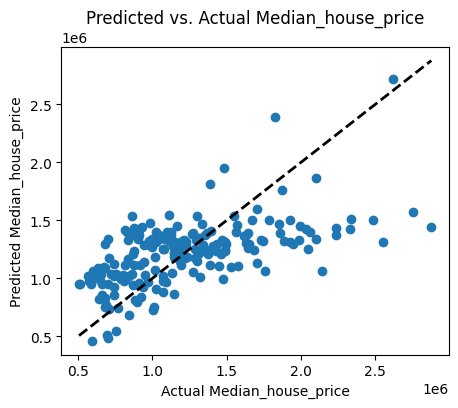

In [33]:
model, df_ = calculate_regression_and_show(housing, formula)

We get a pretty low R2 of 0.338 and residuals are not normally distributed Now, let's have a look at the residuals of the model.

Moreover, we can see on the plot, that the relationship between median_house_price and the linear cobination of population, aus_born_perc, number_of_houses, number_of_units is not linear.

In [34]:
model_compare_dict = {}

In [35]:
# Graph the distribution of model residual

def graph_residuals(model_name, model, df):
    # Calculate the residuals
    residuals = model.resid

    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the distribution of residuals in the first subplot
    sns.histplot(residuals, kde=True, ax=axs[0])
    axs[0].set_xlabel('Residuals')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Distribution of Model Residuals')

    # Q-Q plot in the second subplot
    stats.probplot(residuals, dist="norm", plot=axs[1])
    axs[1].set_title("Q-Q Plot of Residuals")

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    # Perform Shapiro-Wilk test on residuals
    shapiro_test_residuals = stats.shapiro(residuals)
    print("Shapiro-Wilk Test for Residuals:")
    print(f"Test Statistic: {shapiro_test_residuals.statistic}")
    print(f"P-value: {shapiro_test_residuals.pvalue}")

    if shapiro_test_residuals.pvalue > 0.05:
        print("The residuals are likely normally distributed (fail to reject H0).")
    else:
        print("The residuals are not likely normally distributed (reject H0).")

    model_compare_dict[model_name] = {'Test-statistics': shapiro_test_residuals.statistic,
                                      'p_value': shapiro_test_residuals.pvalue}

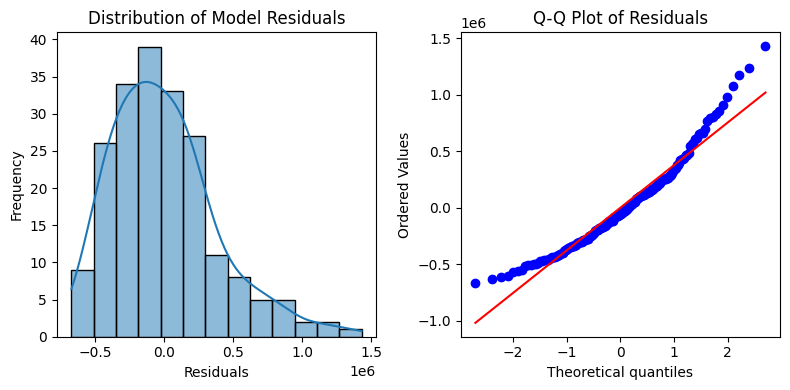

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9475840165603622
P-value: 9.953372600134296e-07
The residuals are not likely normally distributed (reject H0).


In [36]:
graph_residuals('base_model', model, df_)

In [37]:
model_compare_dict

{'base_model': {'Test-statistics': 0.9475840165603622,
  'p_value': 9.953372600134296e-07}}

Our model has R2 of 0.34. It means that our model does not fit the data well. We will keep it as a baseline for comparison. Now we do transformations of numerical features

In [38]:
housing.columns

Index(['suburb', 'number_of_houses', 'number_of_units', 'municipality',
       'aus_born_perc', 'median_income', 'median_house_price', 'population',
       'predicted_median_house_price'],
      dtype='object')

We will carry out some transformations and choose the one the make our data closest to normal distribution. We will take the transformed feature name (transformed by the best transformation we pick) and append to a selected_features list for future use.

In [39]:
selected_features = []

Our aims in transformation is to get the transformed feature to be as normally distributed as possible.

Our approach for transformation is as follow:
1. Test out different transformation (i.e. root, log, boxcox, and robust scaling)
2. Graph the transformed feature distribution and a Q-Q plot of the transformed feature distribution for visualisation
3. Perform Shapiro Wilk test (test for normally distributed data) to see if we achieve normal distribution
4. Take out the transformation that resulting in the one with closest to normal distribution.


# 0.Median_house_price

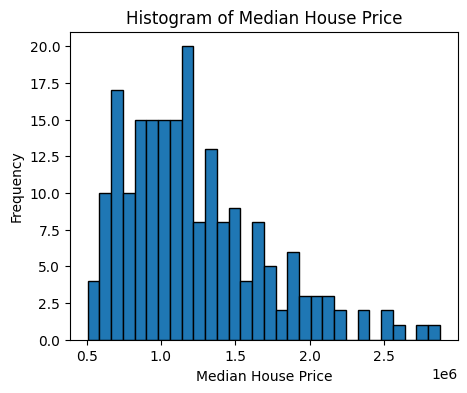

In [40]:
# Create a histogram for median_house_price
plt.figure(figsize=(5, 4))
plt.hist(housing['median_house_price'], bins=30, edgecolor='black')
plt.xlabel('Median House Price')
plt.ylabel('Frequency')
plt.title('Histogram of Median House Price')
plt.show()

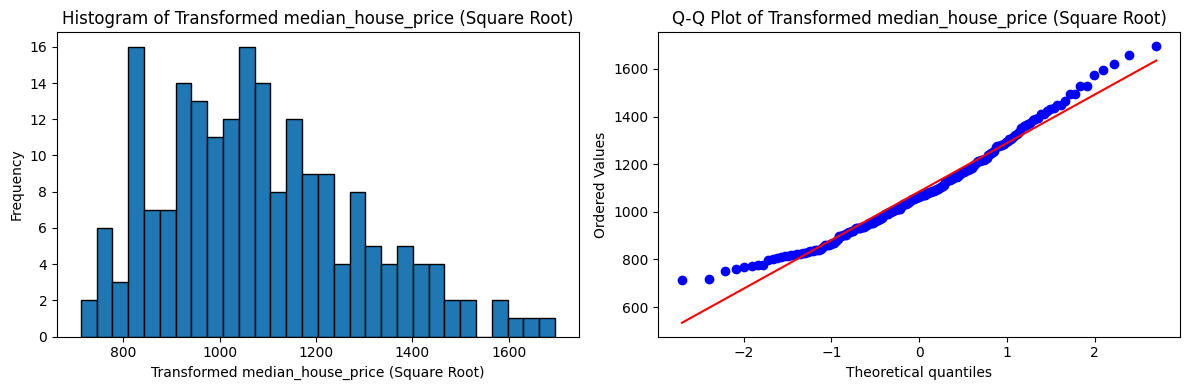

Statistical Results:
Kurtosis: -0.0555
Skewness: 0.5883
Shapiro-Wilk Test Statistic: 0.9706, p-value: 0.0003
The transformed data is not normally distributed (reject H0).


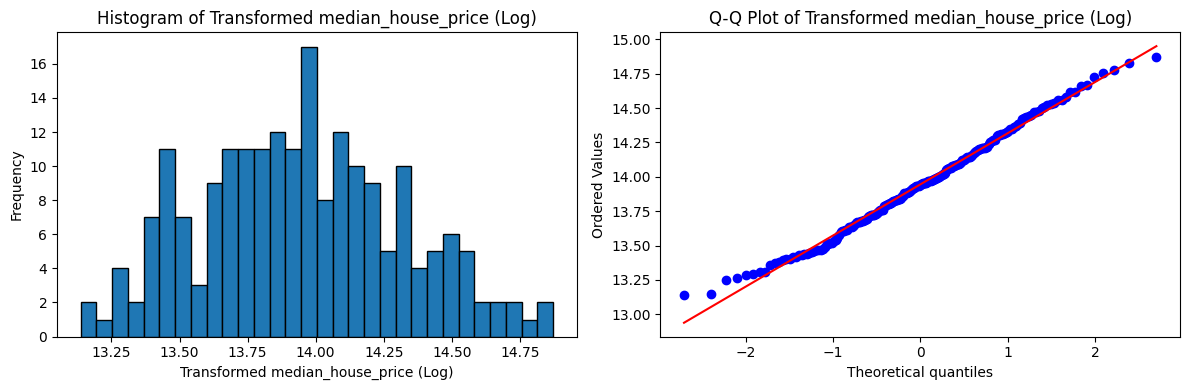

Statistical Results:
Kurtosis: -0.5013
Skewness: 0.1717
Shapiro-Wilk Test Statistic: 0.9908, p-value: 0.2242
The transformed data is normally distributed (fail to reject H0).


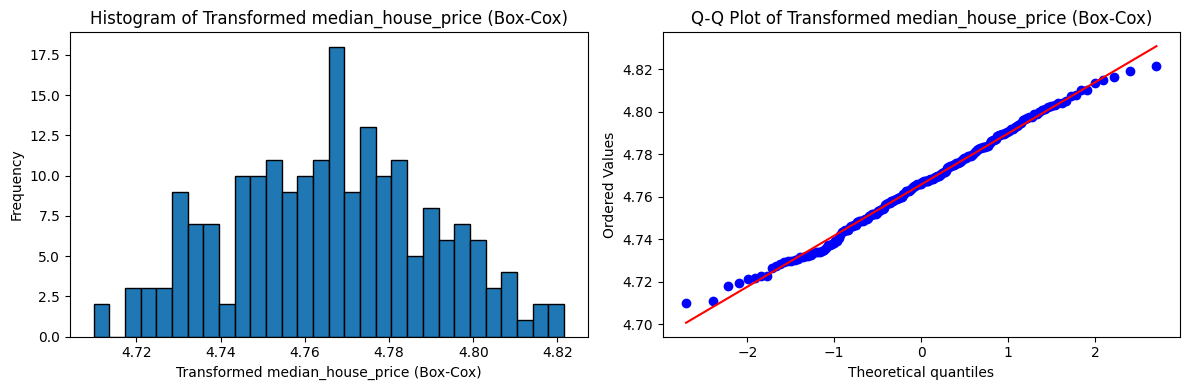

Lambda value for Box-Cox transformation: -0.19618992997667167
Statistical Results:
Kurtosis: -0.5548
Skewness: 0.0134
Shapiro-Wilk Test Statistic: 0.9925, p-value: 0.3895
The transformed data is normally distributed (fail to reject H0).
The best transformation is boxcox


In [41]:
median_house_price_result, median_house_price_best_transform = graph_all_transformations(housing, 'median_house_price')

In [42]:
median_house_price_best_transform

'boxcox'

Despite the fact that boxcox showed a better result, we prefer to work with the logarithm, because there are economic models that explain the linear dependence of the price logarithm on other indicators.

An example of such a model. Suppose we analyze the distribution of house prices on the median income in a location. If the average income in a location is high, then house prices begin to grow. Residents of the area can afford to better equip the area, which attracts even more affluent people. As a result, house prices grow even faster. That is, in this model, it is not house prices that depend on income, but the annual growth rate of houses that depends on income. If the annual growth rate of houses has a normal distribution, then in a few years house prices will be distributed lognormally, since the price growth rate is equal to the difference in the logarithms of prices. As a result, it is quite natural to consider the dependence of the logarithm of the median house price on a linear combination of other factors.

In [43]:
# Append the best transformed feature to the selected features list
selected_features.append('median_house_price_log')

It is worth noting that when we build a linear model using 'median_house_price_log' as a targeted variable instead of 'median_house_price', we would predict median_house_price_log. If we want to get back to median_house_price, we will need to inverse the transformation after we get the predicted values.

# 1.Population

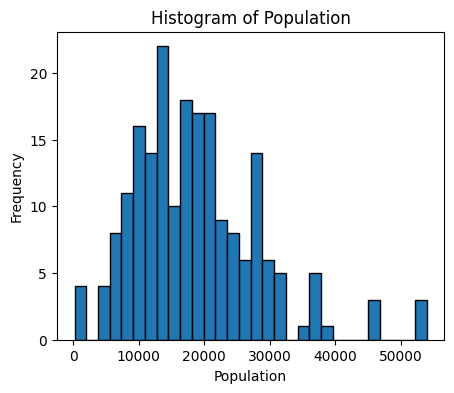

In [44]:
# Create a histogram for population
plt.figure(figsize=(5, 4))
plt.hist(housing['population'], bins=30, edgecolor='black')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.title('Histogram of Population')
plt.show()

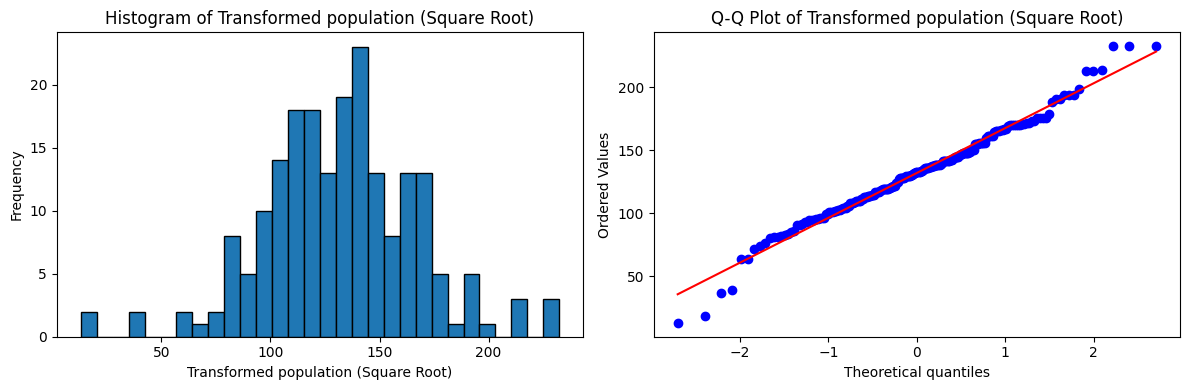

Statistical Results:
Kurtosis: 1.0042
Skewness: -0.0286
Shapiro-Wilk Test Statistic: 0.9840, p-value: 0.0217
The transformed data is not normally distributed (reject H0).


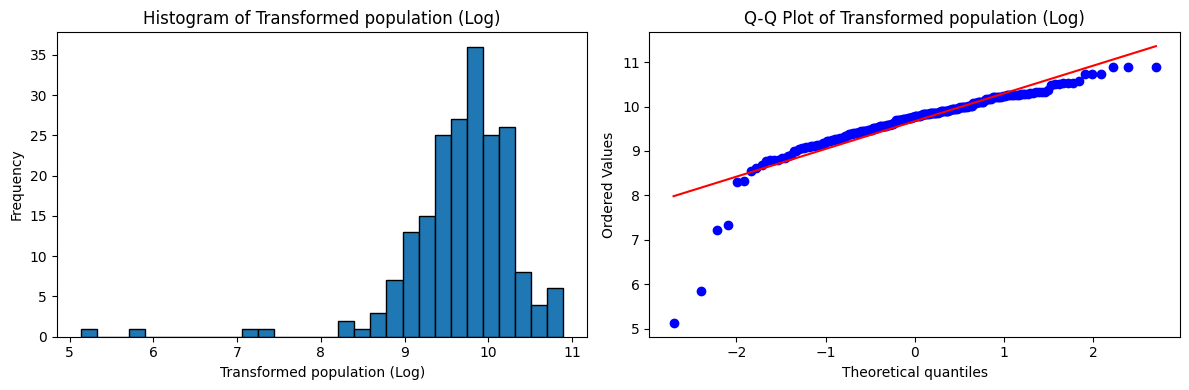

Statistical Results:
Kurtosis: 13.2703
Skewness: -2.6254
Shapiro-Wilk Test Statistic: 0.8130, p-value: 0.0000
The transformed data is not normally distributed (reject H0).


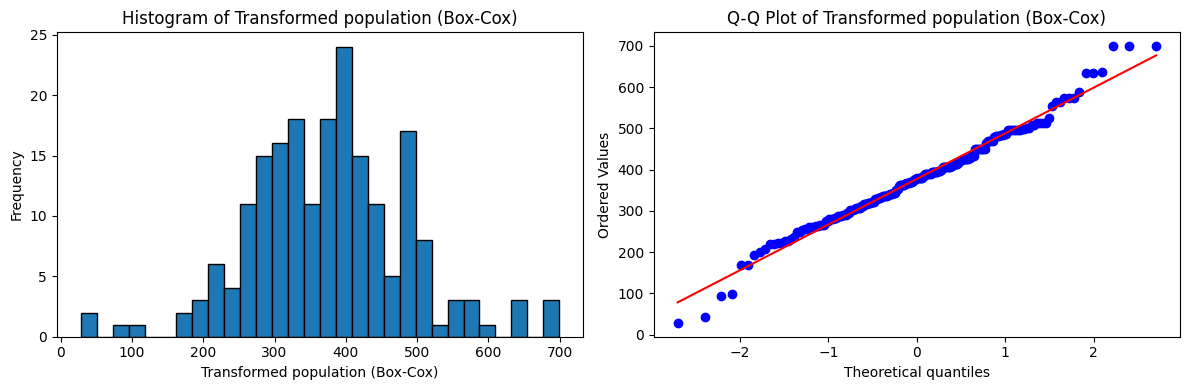

Lambda value for Box-Cox transformation: 0.545753437551949
Statistical Results:
Kurtosis: 0.8887
Skewness: 0.0997
Shapiro-Wilk Test Statistic: 0.9848, p-value: 0.0288
The transformed data is not normally distributed (reject H0).
The best transformation is boxcox


In [45]:
population_result, population_best_transform = graph_all_transformations(housing, 'population')

In [46]:
population_best_transform

'boxcox'

In [47]:
# Append the best transformed feature to the selected features list
selected_features.append('population_bc')

# 2.aus_born_perc

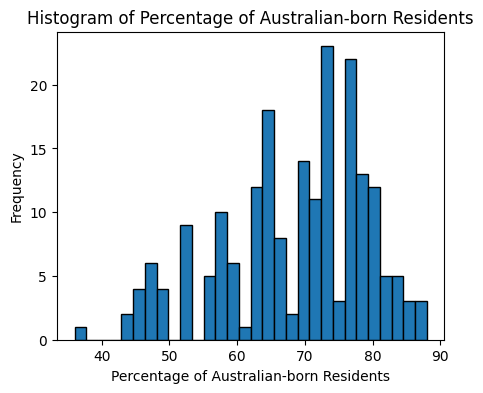

In [48]:
# Create a histogram for aus_born_perc
plt.figure(figsize=(5, 4))
plt.hist(housing['aus_born_perc'], bins=30, edgecolor='black')
plt.xlabel('Percentage of Australian-born Residents')
plt.ylabel('Frequency')
plt.title('Histogram of Percentage of Australian-born Residents')
plt.show()

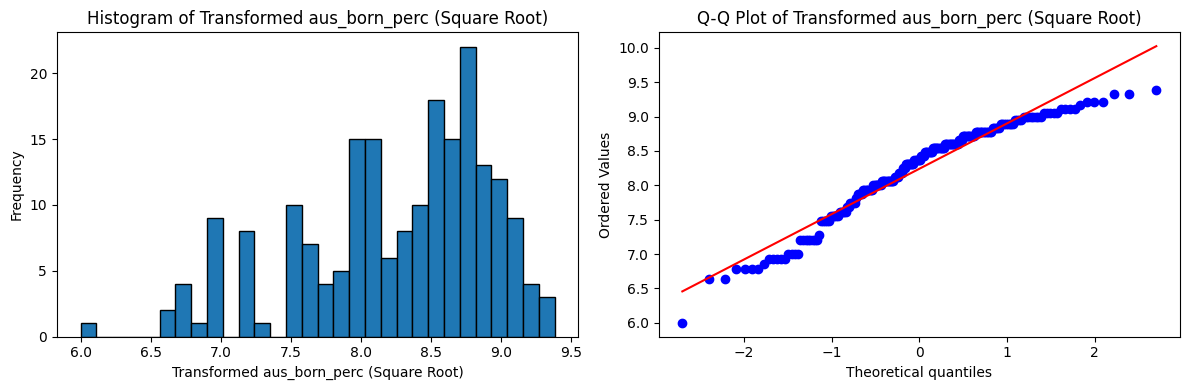

Statistical Results:
Kurtosis: -0.0899
Skewness: -0.7327
Shapiro-Wilk Test Statistic: 0.9462, p-value: 0.0000
The transformed data is not normally distributed (reject H0).


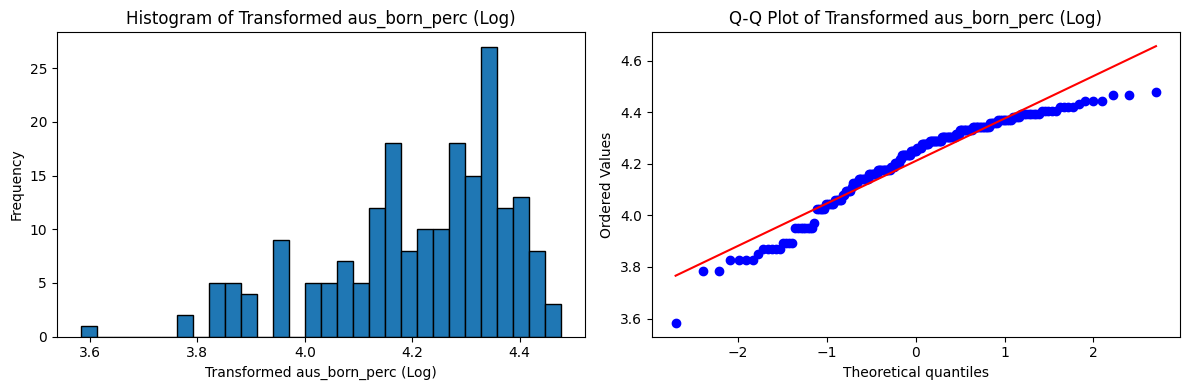

Statistical Results:
Kurtosis: 0.3654
Skewness: -0.9169
Shapiro-Wilk Test Statistic: 0.9282, p-value: 0.0000
The transformed data is not normally distributed (reject H0).


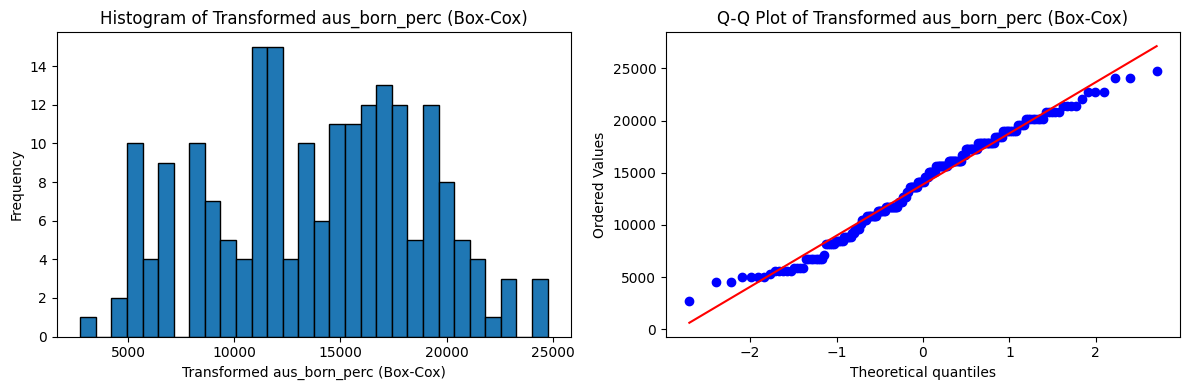

Lambda value for Box-Cox transformation: 2.460678666538589
Statistical Results:
Kurtosis: -0.8060
Skewness: -0.1277
Shapiro-Wilk Test Statistic: 0.9798, p-value: 0.0052
The transformed data is not normally distributed (reject H0).
The best transformation is boxcox


In [49]:
aus_born_perc_result, aus_born_perc_best_transform = graph_all_transformations(housing, 'aus_born_perc')

In [50]:
aus_born_perc_best_transform

'boxcox'

In [51]:
selected_features.append('aus_born_perc_bc')

# 3.Number_of_houses

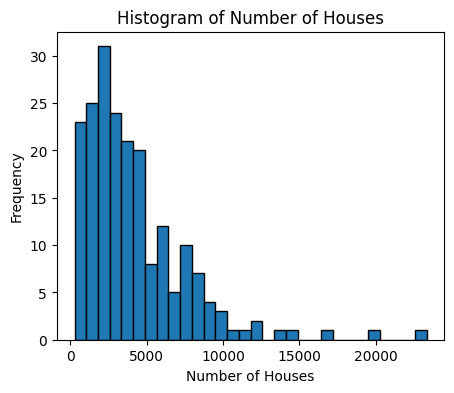

In [52]:
# Create a histogram for number_of_houses
plt.figure(figsize=(5, 4))
plt.hist(housing['number_of_houses'], bins=30, edgecolor='black')
plt.xlabel('Number of Houses')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Houses')
plt.show()

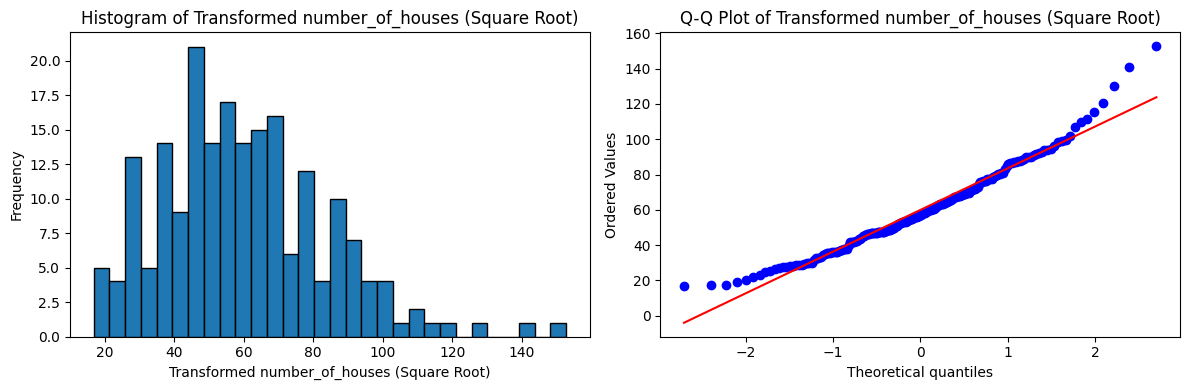

Statistical Results:
Kurtosis: 0.9792
Skewness: 0.7568
Shapiro-Wilk Test Statistic: 0.9663, p-value: 0.0001
The transformed data is not normally distributed (reject H0).


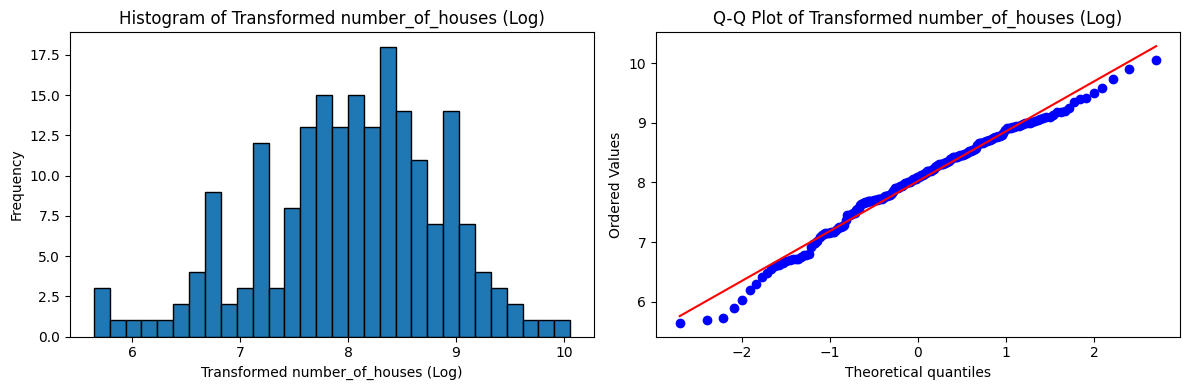

Statistical Results:
Kurtosis: 0.1033
Skewness: -0.4392
Shapiro-Wilk Test Statistic: 0.9839, p-value: 0.0205
The transformed data is not normally distributed (reject H0).


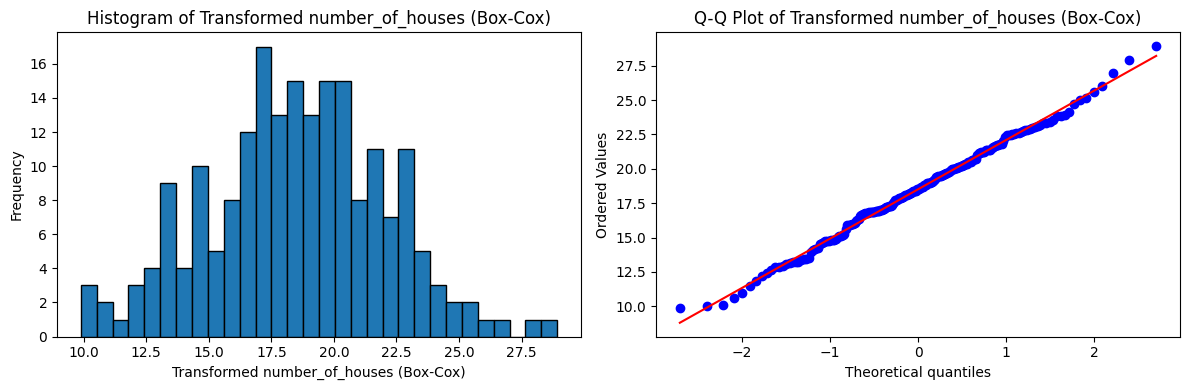

Lambda value for Box-Cox transformation: 0.18280267261662375
Statistical Results:
Kurtosis: -0.0737
Skewness: -0.0064
Shapiro-Wilk Test Statistic: 0.9955, p-value: 0.8093
The transformed data is normally distributed (fail to reject H0).
The best transformation is boxcox


In [53]:
number_of_house_result, number_of_house_best_transform = graph_all_transformations(housing, 'number_of_houses')

In [54]:
number_of_house_best_transform

'boxcox'

In [55]:
selected_features.append('number_of_houses_bc')

# 4.Number of unit

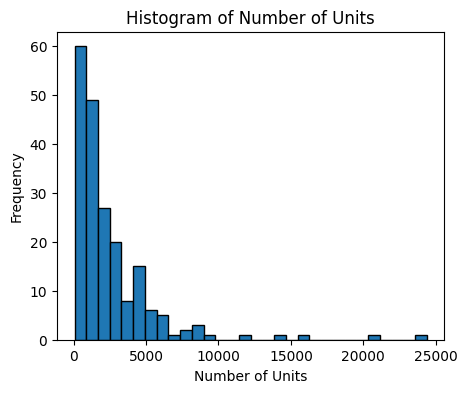

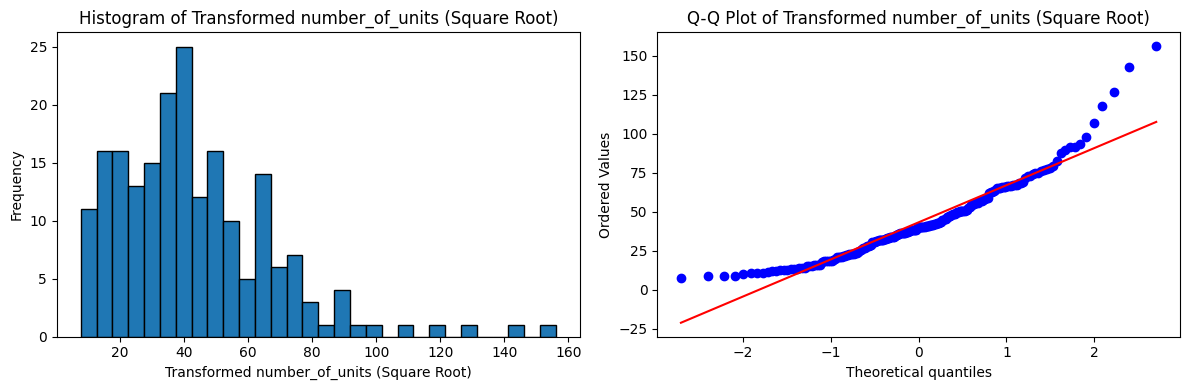

Statistical Results:
Kurtosis: 2.9562
Skewness: 1.3141
Shapiro-Wilk Test Statistic: 0.9146, p-value: 0.0000
The transformed data is not normally distributed (reject H0).


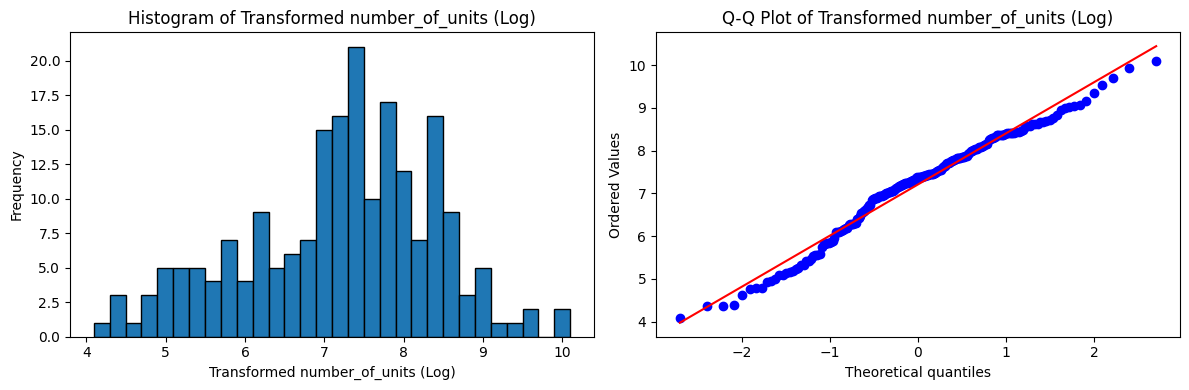

Statistical Results:
Kurtosis: -0.2188
Skewness: -0.3965
Shapiro-Wilk Test Statistic: 0.9785, p-value: 0.0034
The transformed data is not normally distributed (reject H0).


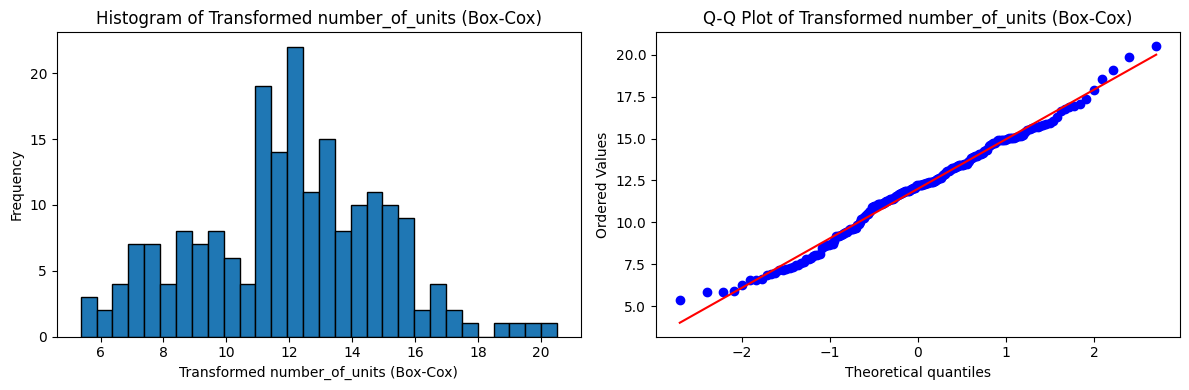

Lambda value for Box-Cox transformation: 0.12690019525423166
Statistical Results:
Kurtosis: -0.1935
Skewness: -0.0140
Shapiro-Wilk Test Statistic: 0.9894, p-value: 0.1432
The transformed data is normally distributed (fail to reject H0).
The best transformation is boxcox


In [56]:
# Create a histogram for number_of_units
plt.figure(figsize=(5, 4))
plt.hist(housing['number_of_units'], bins=30, edgecolor='black')
plt.xlabel('Number of Units')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Units')
plt.show()

number_of_units_result, number_of_units_best_transform = graph_all_transformations(housing, 'number_of_units')

In [57]:
number_of_units_best_transform

'boxcox'

In [58]:
selected_features.append('number_of_units_bc')

#5.Median income

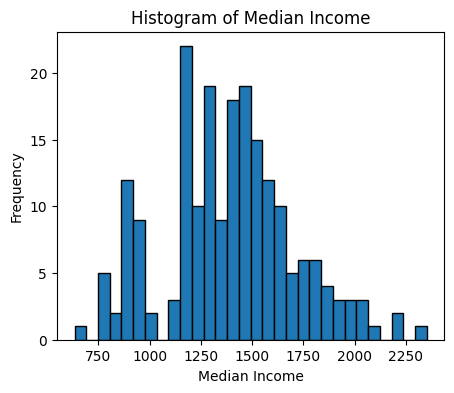

In [59]:
# Create a histogram for median_income
plt.figure(figsize=(5, 4))
plt.hist(housing['median_income'], bins=30, edgecolor='black')
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.title('Histogram of Median Income')
plt.show()

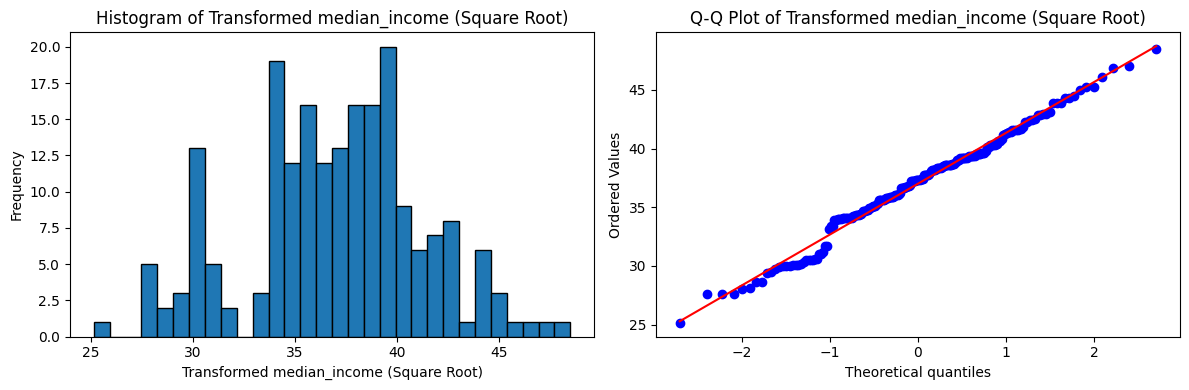

Statistical Results:
Kurtosis: -0.0831
Skewness: -0.1645
Shapiro-Wilk Test Statistic: 0.9874, p-value: 0.0702
The transformed data is normally distributed (fail to reject H0).


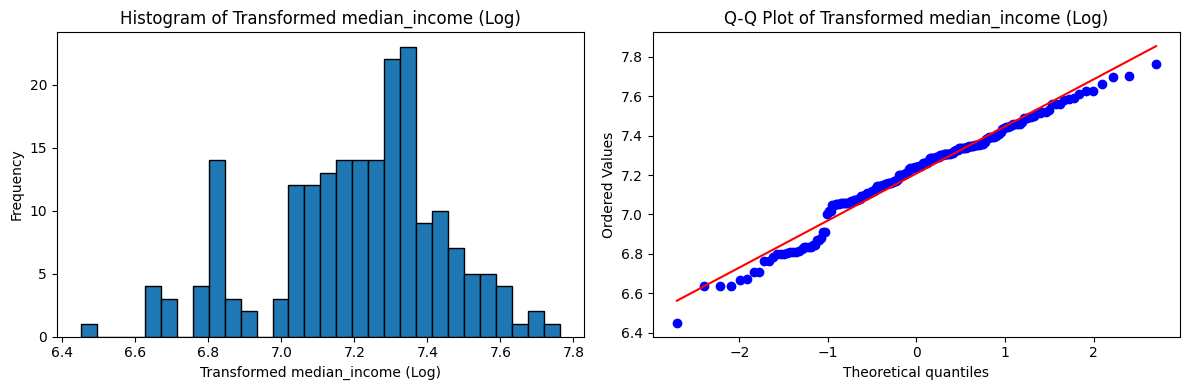

Statistical Results:
Kurtosis: 0.1046
Skewness: -0.4979
Shapiro-Wilk Test Statistic: 0.9737, p-value: 0.0008
The transformed data is not normally distributed (reject H0).


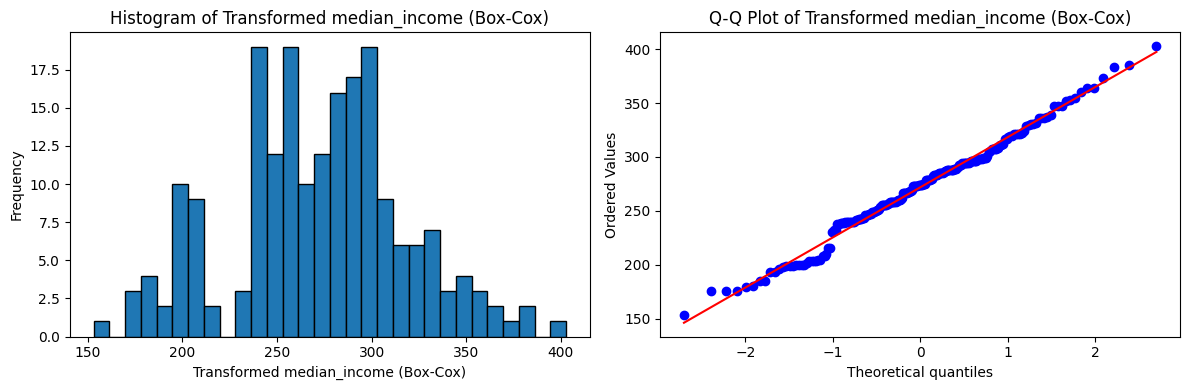

Lambda value for Box-Cox transformation: 0.7331502172628451
Statistical Results:
Kurtosis: -0.0712
Skewness: -0.0083
Shapiro-Wilk Test Statistic: 0.9894, p-value: 0.1422
The transformed data is normally distributed (fail to reject H0).
The best transformation is boxcox


In [60]:
median_income_result, median_income_best_transform = graph_all_transformations(housing, 'median_income')

In [61]:
median_house_price_best_transform

'boxcox'

In [62]:
selected_features.append('median_income_bc')

# Run linear regression on transformed variables and test different transformed features for linear regression

## Model 2

In [63]:
selected_features

['median_house_price_log',
 'population_bc',
 'aus_born_perc_bc',
 'number_of_houses_bc',
 'number_of_units_bc',
 'median_income_bc']

                              OLS Regression Results                              
Dep. Variable:     median_house_price_log   R-squared:                       0.683
Model:                                OLS   Adj. R-squared:                  0.675
Method:                     Least Squares   F-statistic:                     84.35
Date:                    Fri, 18 Oct 2024   Prob (F-statistic):           5.83e-47
Time:                            11:25:35   Log-Likelihood:                 30.580
No. Observations:                     202   AIC:                            -49.16
Df Residuals:                         196   BIC:                            -29.31
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

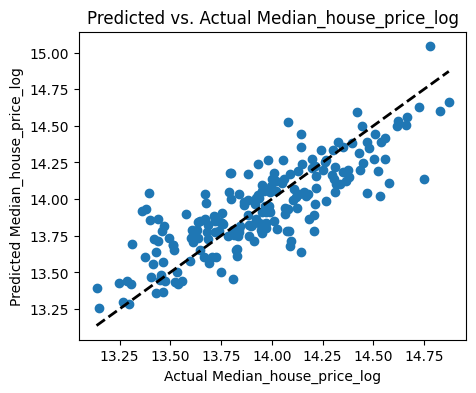

In [64]:
# Try regression with the transformed features
formula2 = 'median_house_price_log ~ population_bc + aus_born_perc_bc  + number_of_houses_bc + median_income_bc + number_of_units_bc'
model2, df2 = calculate_regression_and_show(housing, formula2)

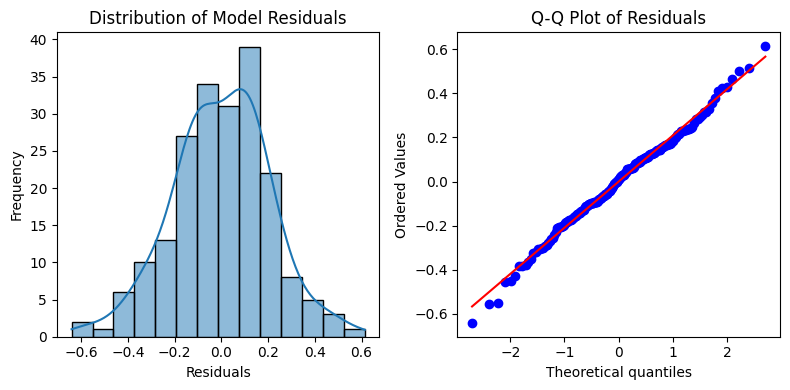

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9943895120507031
P-value: 0.6515988560342179
The residuals are likely normally distributed (fail to reject H0).


In [65]:
graph_residuals('model2', model2, df2)

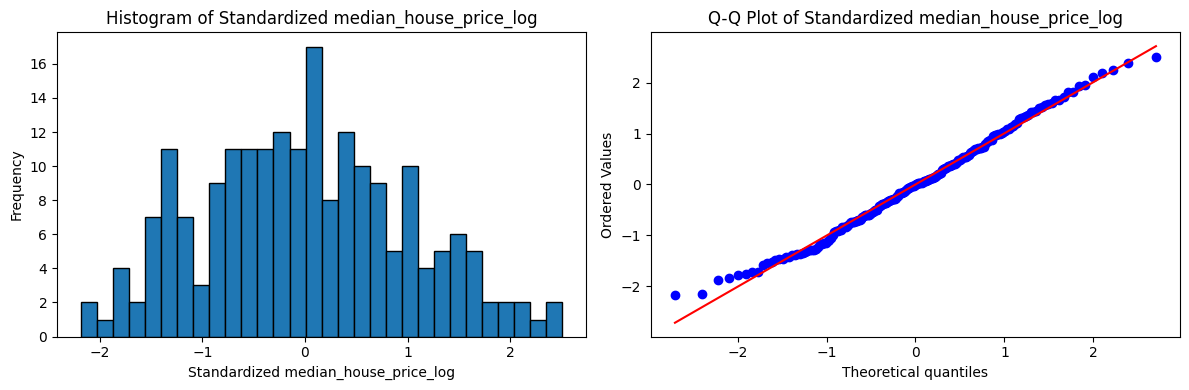

Kurtosis of median_house_price_log: -0.5012627795433828
Skewness of median_house_price_log: 0.17165776276638403
Shapiro-Wilk Test Statistic: 0.9907625914358906, p-value: 0.22416694143679172
The transformed data is normally distributed (fail to reject H0).


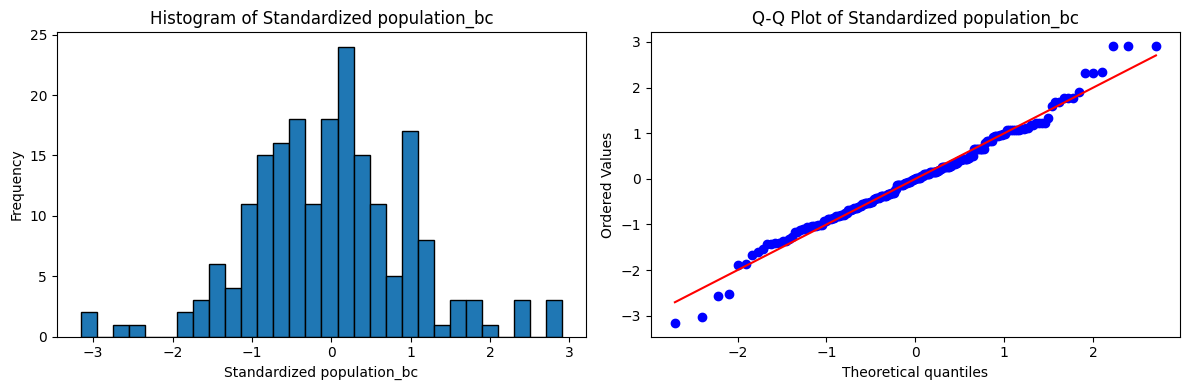

Kurtosis of population_bc: 0.8886897518280552
Skewness of population_bc: 0.09973484407248041
Shapiro-Wilk Test Statistic: 0.9848377985593209, p-value: 0.028785994692566055
The transformed data is not normally distributed (reject H0).


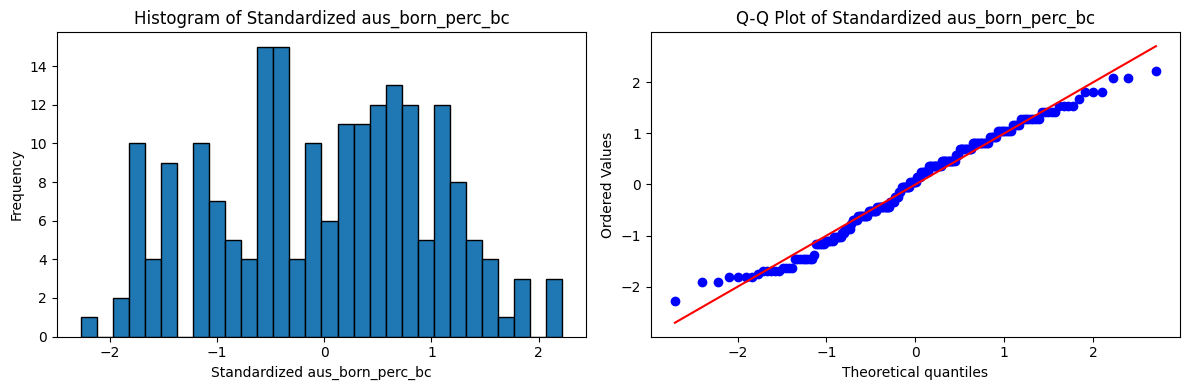

Kurtosis of aus_born_perc_bc: -0.8060249900714367
Skewness of aus_born_perc_bc: -0.1276650111055119
Shapiro-Wilk Test Statistic: 0.9797553375167413, p-value: 0.005167412268870875
The transformed data is not normally distributed (reject H0).


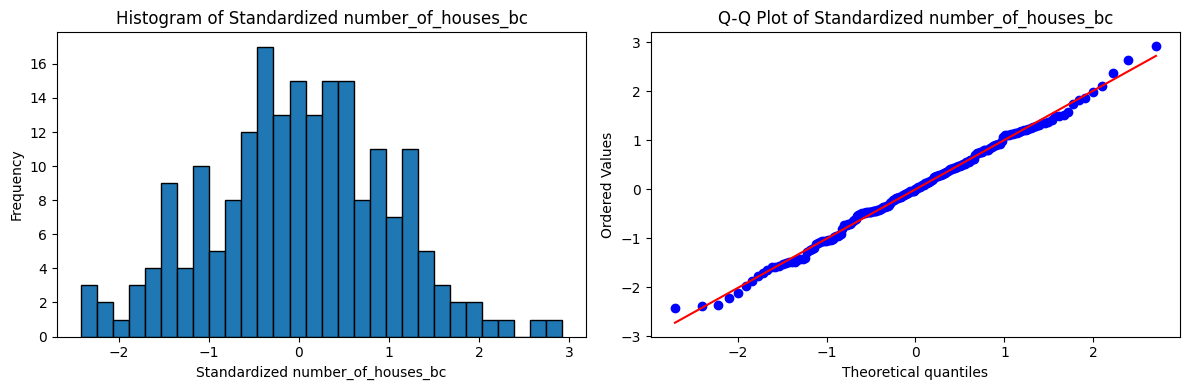

Kurtosis of number_of_houses_bc: -0.07374251261555775
Skewness of number_of_houses_bc: -0.0063579167705099734
Shapiro-Wilk Test Statistic: 0.9954566706600854, p-value: 0.8092981995076867
The transformed data is normally distributed (fail to reject H0).


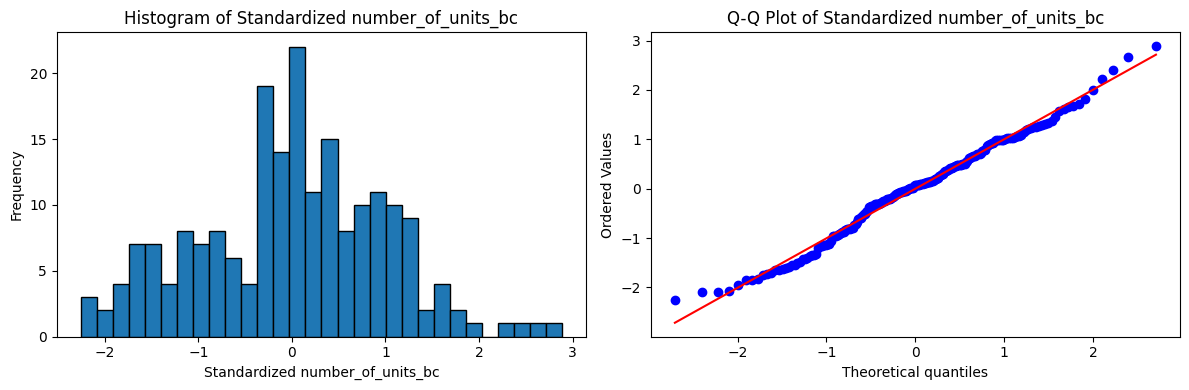

Kurtosis of number_of_units_bc: -0.19351985188043042
Skewness of number_of_units_bc: -0.014002383925762434
Shapiro-Wilk Test Statistic: 0.9894402406301278, p-value: 0.14317128735611706
The transformed data is normally distributed (fail to reject H0).


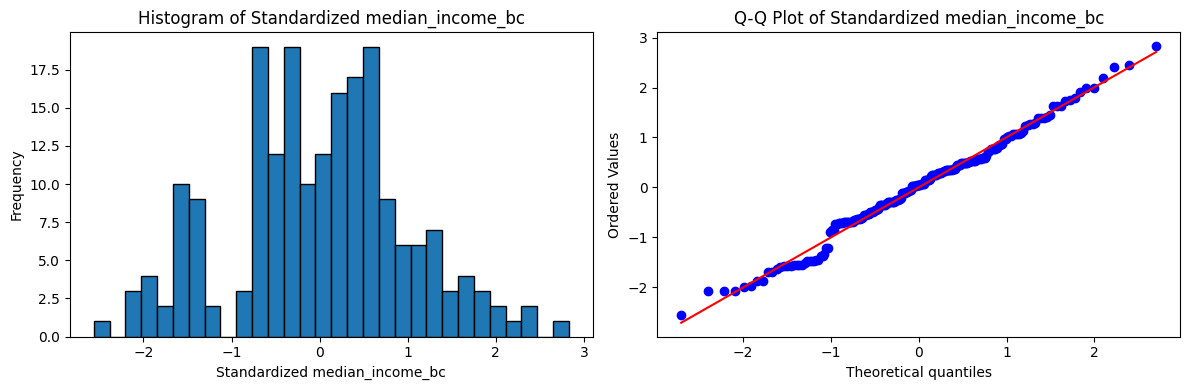

Kurtosis of median_income_bc: -0.07115085370761554
Skewness of median_income_bc: -0.008346732789838829
Shapiro-Wilk Test Statistic: 0.9894194453654755, p-value: 0.14215032185540882
The transformed data is normally distributed (fail to reject H0).


In [66]:
# Standardise all feature in selected_features so that they are on the same scale
for col in selected_features:
  standardize_column(housing, col)

In [67]:
housing.columns

Index(['suburb', 'number_of_houses', 'number_of_units', 'municipality',
       'aus_born_perc', 'median_income', 'median_house_price', 'population',
       'predicted_median_house_price', 'median_house_price_sqrt',
       'median_house_price_log', 'median_house_price_bc', 'population_sqrt',
       'population_log', 'population_bc', 'aus_born_perc_sqrt',
       'aus_born_perc_log', 'aus_born_perc_bc', 'number_of_houses_sqrt',
       'number_of_houses_log', 'number_of_houses_bc', 'number_of_units_sqrt',
       'number_of_units_log', 'number_of_units_bc', 'median_income_sqrt',
       'median_income_log', 'median_income_bc',
       'predicted_median_house_price_log',
       'median_house_price_log_standardized', 'population_bc_standardized',
       'aus_born_perc_bc_standardized', 'number_of_houses_bc_standardized',
       'number_of_units_bc_standardized', 'median_income_bc_standardized'],
      dtype='object')

## Model 3

                                     OLS Regression Results                                    
Dep. Variable:     median_house_price_log_standardized   R-squared:                       0.683
Model:                                             OLS   Adj. R-squared:                  0.675
Method:                                  Least Squares   F-statistic:                     84.35
Date:                                 Fri, 18 Oct 2024   Prob (F-statistic):           5.83e-47
Time:                                         11:25:40   Log-Likelihood:                -170.18
No. Observations:                                  202   AIC:                             352.4
Df Residuals:                                      196   BIC:                             372.2
Df Model:                                            5                                         
Covariance Type:                             nonrobust                                         
                                       c

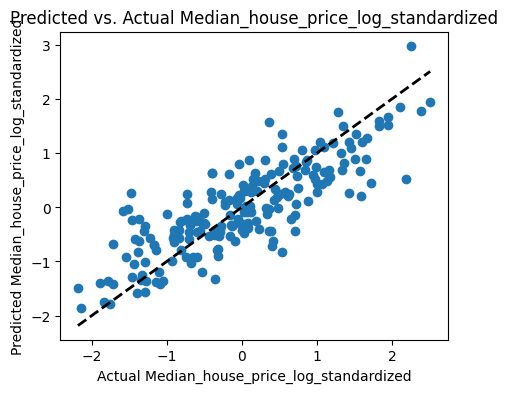

In [68]:
# Re-run regression with standardised features
formula3 = 'median_house_price_log_standardized ~ population_bc_standardized + aus_born_perc_bc_standardized  + number_of_houses_bc_standardized + median_income_bc_standardized + number_of_units_bc_standardized'
model3, df3 = calculate_regression_and_show(housing, formula3)

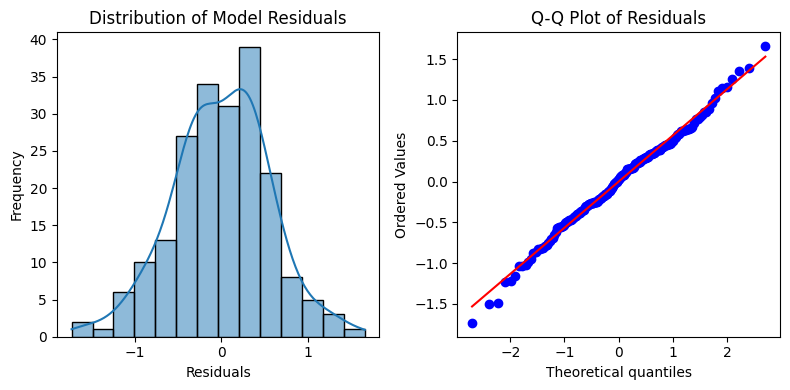

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9943895120507038
P-value: 0.6515988560343049
The residuals are likely normally distributed (fail to reject H0).


In [69]:
graph_residuals('model3', model3, df3)

## Model 4

                            OLS Regression Results                            
Dep. Variable:     median_house_price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     79.52
Date:                Fri, 18 Oct 2024   Prob (F-statistic):           2.83e-45
Time:                        11:25:41   Log-Likelihood:                -2813.1
No. Observations:                 202   AIC:                             5638.
Df Residuals:                     196   BIC:                             5658.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -7.512e+05   1

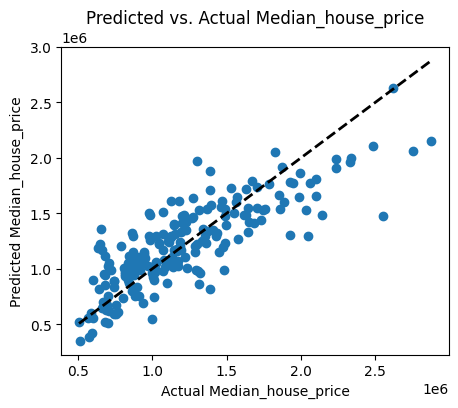

In [70]:
formula4 = 'median_house_price ~ population_bc + aus_born_perc_bc  + number_of_houses_bc + median_income_bc + number_of_units_bc'
model4, df4 = calculate_regression_and_show(housing, formula4)

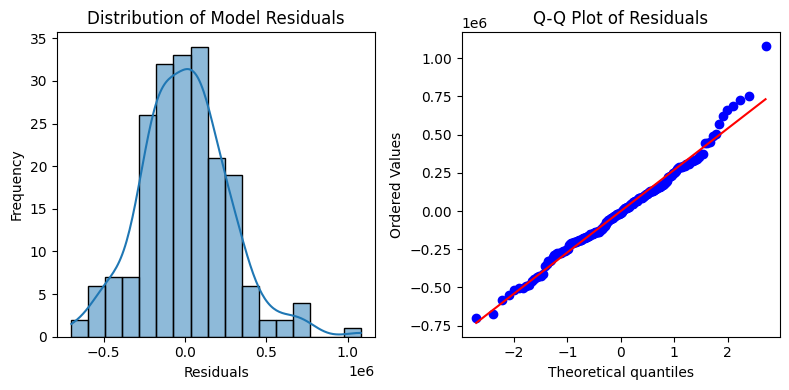

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9830840386836711
P-value: 0.01574194925526312
The residuals are not likely normally distributed (reject H0).


In [71]:
graph_residuals('model4', model4, df4)

## Model 5

                            OLS Regression Results                            
Dep. Variable:     median_house_price   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     79.82
Date:                Fri, 18 Oct 2024   Prob (F-statistic):           2.22e-45
Time:                        11:25:42   Log-Likelihood:                -2812.9
No. Observations:                 202   AIC:                             5638.
Df Residuals:                     196   BIC:                             5658.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -6.495e+05   1

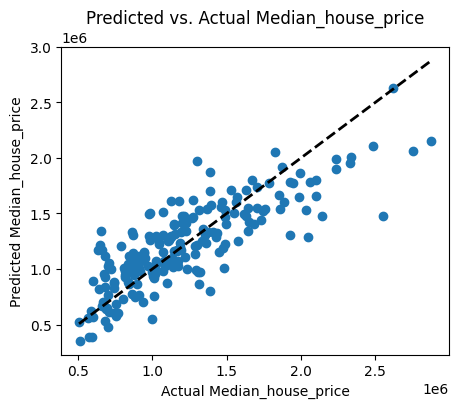

In [72]:
formula5 = 'median_house_price ~ population + aus_born_perc  + number_of_houses_bc + median_income_bc + number_of_units_bc'
model5, df5 = calculate_regression_and_show(housing, formula5)

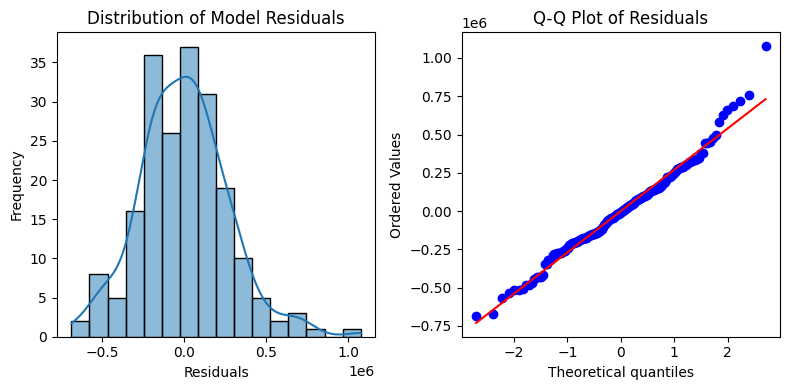

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9825633991168766
P-value: 0.013186143281282613
The residuals are not likely normally distributed (reject H0).


In [73]:
graph_residuals('model5', model5, df5)

## Model 6

                              OLS Regression Results                              
Dep. Variable:     median_house_price_log   R-squared:                       0.684
Model:                                OLS   Adj. R-squared:                  0.676
Method:                     Least Squares   F-statistic:                     84.79
Date:                    Fri, 18 Oct 2024   Prob (F-statistic):           4.13e-47
Time:                            11:25:43   Log-Likelihood:                 30.939
No. Observations:                     202   AIC:                            -49.88
Df Residuals:                         196   BIC:                            -30.03
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

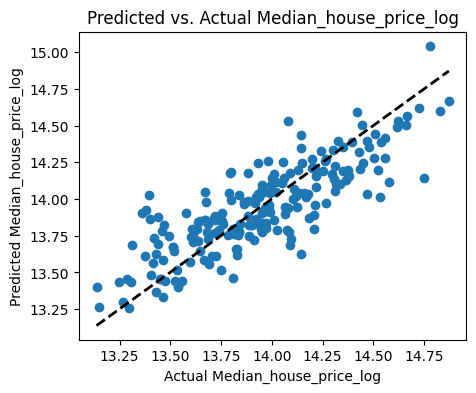

In [74]:
formula6 = 'median_house_price_log ~ population + aus_born_perc_bc + number_of_houses_bc + median_income_bc + number_of_units_bc'
model6, df6 = calculate_regression_and_show(housing, formula6)

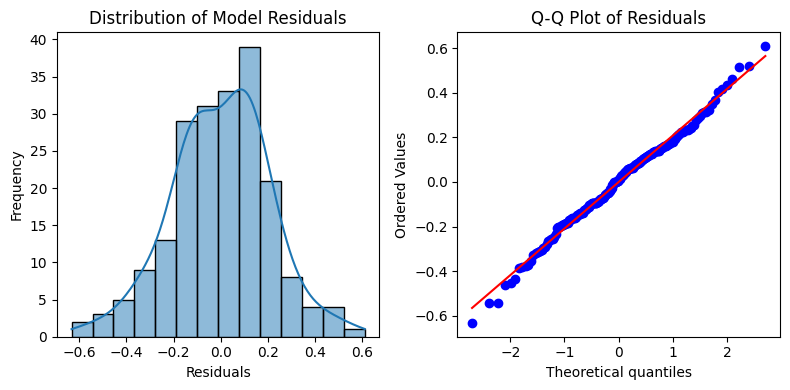

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9938213195867591
P-value: 0.5665402649952604
The residuals are likely normally distributed (fail to reject H0).


In [75]:
graph_residuals('model6', model6, df6)

## Model 7

                              OLS Regression Results                              
Dep. Variable:     median_house_price_log   R-squared:                       0.684
Model:                                OLS   Adj. R-squared:                  0.676
Method:                     Least Squares   F-statistic:                     84.81
Date:                    Fri, 18 Oct 2024   Prob (F-statistic):           4.09e-47
Time:                            11:25:44   Log-Likelihood:                 30.950
No. Observations:                     202   AIC:                            -49.90
Df Residuals:                         196   BIC:                            -30.05
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

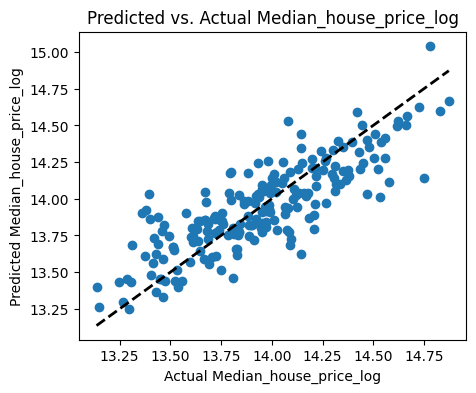

In [76]:
formula7 = 'median_house_price_log ~ population + aus_born_perc + number_of_houses_bc + median_income_bc + number_of_units_bc'
model7, df7 = calculate_regression_and_show(housing, formula7)

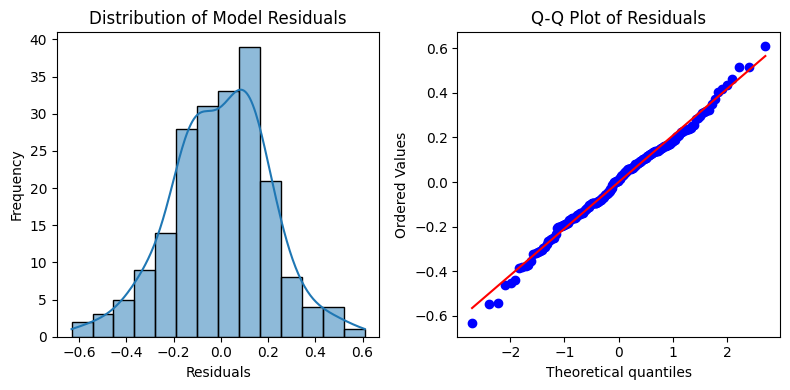

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9939014821362113
P-value: 0.5783344826000236
The residuals are likely normally distributed (fail to reject H0).


In [77]:
graph_residuals('model7', model7, df7)

## Model 8

                              OLS Regression Results                              
Dep. Variable:     median_house_price_log   R-squared:                       0.686
Model:                                OLS   Adj. R-squared:                  0.678
Method:                     Least Squares   F-statistic:                     85.56
Date:                    Fri, 18 Oct 2024   Prob (F-statistic):           2.27e-47
Time:                            11:25:45   Log-Likelihood:                 31.559
No. Observations:                     202   AIC:                            -51.12
Df Residuals:                         196   BIC:                            -31.27
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

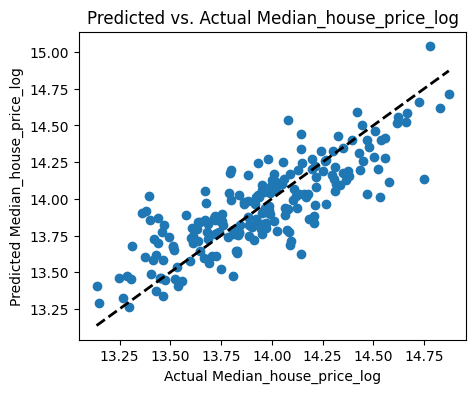

In [78]:
formula8 = 'median_house_price_log ~ population + aus_born_perc + number_of_houses_bc + median_income + number_of_units_bc'
model8, df8 = calculate_regression_and_show(housing, formula8)

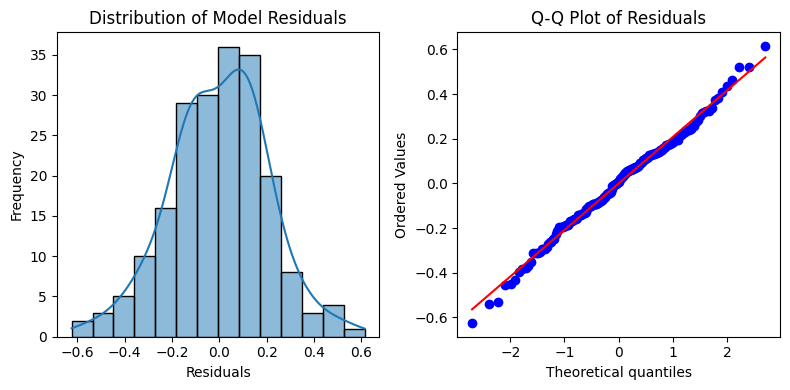

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9943614260376169
P-value: 0.6473387745722369
The residuals are likely normally distributed (fail to reject H0).


In [79]:
graph_residuals('model8', model8, df8)

## Model 9

                              OLS Regression Results                              
Dep. Variable:     median_house_price_log   R-squared:                       0.681
Model:                                OLS   Adj. R-squared:                  0.673
Method:                     Least Squares   F-statistic:                     83.66
Date:                    Fri, 18 Oct 2024   Prob (F-statistic):           1.01e-46
Time:                            11:25:46   Log-Likelihood:                 30.014
No. Observations:                     202   AIC:                            -48.03
Df Residuals:                         196   BIC:                            -28.18
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

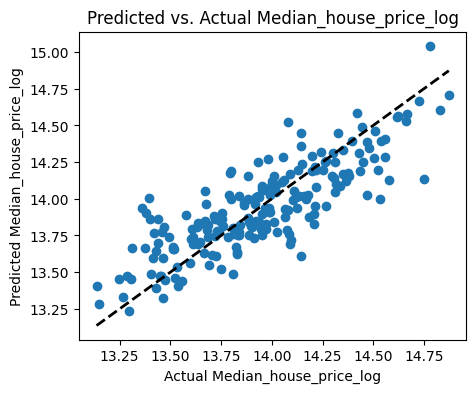

In [80]:
formula9 = 'median_house_price_log ~ population + aus_born_perc + number_of_houses_log + median_income + number_of_units_bc'
model9, df9 = calculate_regression_and_show(housing, formula9)

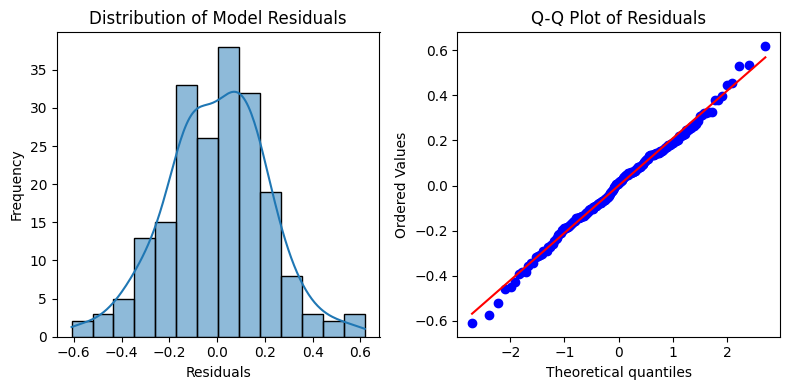

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9951672570641938
P-value: 0.7682678941144665
The residuals are likely normally distributed (fail to reject H0).


In [81]:
graph_residuals('model9', model9, df9)

## Model 10

                              OLS Regression Results                              
Dep. Variable:     median_house_price_log   R-squared:                       0.683
Model:                                OLS   Adj. R-squared:                  0.675
Method:                     Least Squares   F-statistic:                     84.39
Date:                    Fri, 18 Oct 2024   Prob (F-statistic):           5.68e-47
Time:                            11:25:47   Log-Likelihood:                 30.609
No. Observations:                     202   AIC:                            -49.22
Df Residuals:                         196   BIC:                            -29.37
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

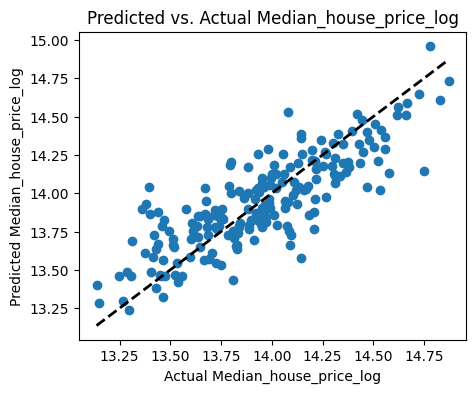

In [82]:
formula10 = 'median_house_price_log ~ population + aus_born_perc + number_of_houses_bc + median_income + number_of_units_log'
model10, df10 = calculate_regression_and_show(housing, formula10)

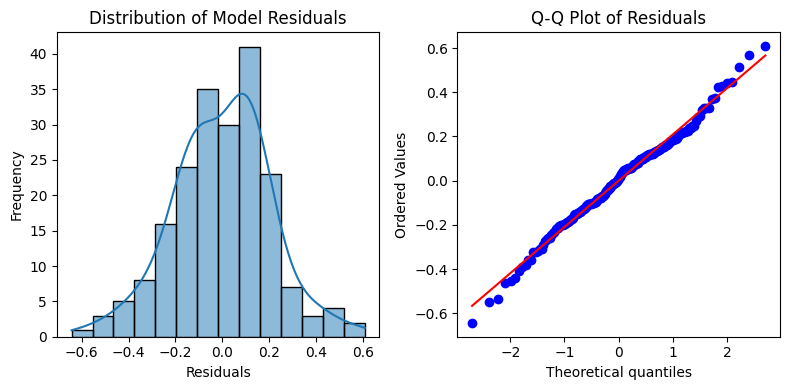

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9924373888065459
P-value: 0.3829696850278915
The residuals are likely normally distributed (fail to reject H0).


In [83]:
graph_residuals('model10', model10, df10)

## Model 11

                              OLS Regression Results                              
Dep. Variable:     median_house_price_log   R-squared:                       0.678
Model:                                OLS   Adj. R-squared:                  0.670
Method:                     Least Squares   F-statistic:                     82.68
Date:                    Fri, 18 Oct 2024   Prob (F-statistic):           2.20e-46
Time:                            11:25:48   Log-Likelihood:                 29.201
No. Observations:                     202   AIC:                            -46.40
Df Residuals:                         196   BIC:                            -26.55
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

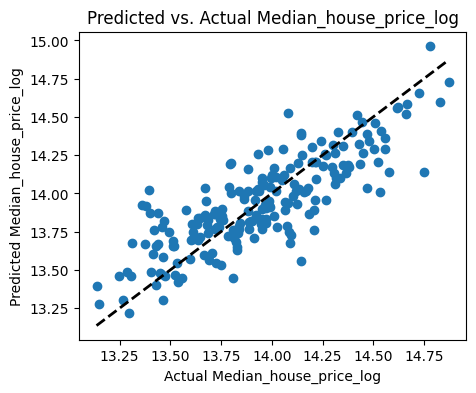

In [84]:
formula11 = 'median_house_price_log ~ population + aus_born_perc + number_of_houses_log + median_income + number_of_units_log'
model11, df11 = calculate_regression_and_show(housing, formula11)

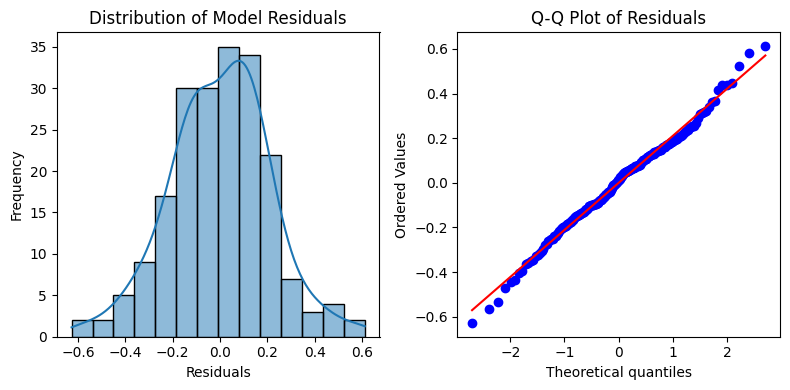

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9935338570886557
P-value: 0.5250724247961187
The residuals are likely normally distributed (fail to reject H0).


In [85]:
graph_residuals('model11', model11, df11)

## Model 12

                              OLS Regression Results                              
Dep. Variable:     median_house_price_log   R-squared:                       0.676
Model:                                OLS   Adj. R-squared:                  0.668
Method:                     Least Squares   F-statistic:                     81.82
Date:                    Fri, 18 Oct 2024   Prob (F-statistic):           4.38e-46
Time:                            11:25:49   Log-Likelihood:                 28.487
No. Observations:                     202   AIC:                            -44.97
Df Residuals:                         196   BIC:                            -25.12
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

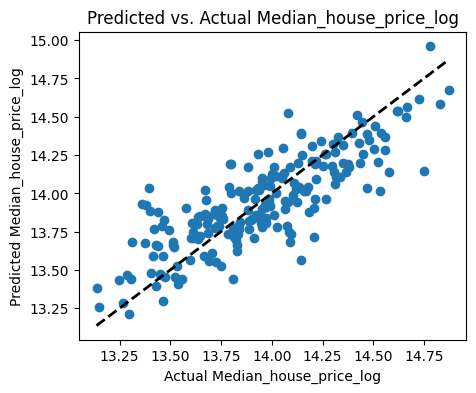

In [86]:
formula12 = 'median_house_price_log ~ population + aus_born_perc + number_of_houses_log + median_income_bc + number_of_units_log'
model12, df12 = calculate_regression_and_show(housing, formula12)

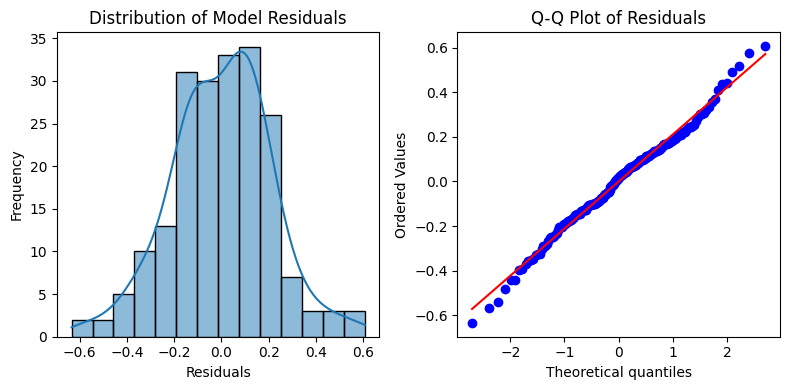

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9926948977286247
P-value: 0.4137375703556105
The residuals are likely normally distributed (fail to reject H0).


In [87]:
graph_residuals('model12', model12, df12)

In [88]:
model_compare_dict

{'base_model': {'Test-statistics': 0.9475840165603622,
  'p_value': 9.953372600134296e-07},
 'model2': {'Test-statistics': 0.9943895120507031,
  'p_value': 0.6515988560342179},
 'model3': {'Test-statistics': 0.9943895120507038,
  'p_value': 0.6515988560343049},
 'model4': {'Test-statistics': 0.9830840386836711,
  'p_value': 0.01574194925526312},
 'model5': {'Test-statistics': 0.9825633991168766,
  'p_value': 0.013186143281282613},
 'model6': {'Test-statistics': 0.9938213195867591,
  'p_value': 0.5665402649952604},
 'model7': {'Test-statistics': 0.9939014821362113,
  'p_value': 0.5783344826000236},
 'model8': {'Test-statistics': 0.9943614260376169,
  'p_value': 0.6473387745722369},
 'model9': {'Test-statistics': 0.9951672570641938,
  'p_value': 0.7682678941144665},
 'model10': {'Test-statistics': 0.9924373888065459,
  'p_value': 0.3829696850278915},
 'model11': {'Test-statistics': 0.9935338570886557,
  'p_value': 0.5250724247961187},
 'model12': {'Test-statistics': 0.9926948977286247,
 

In [89]:
best_model = max(model_compare_dict, key=lambda k: model_compare_dict[k]['Test-statistics'])
print(f"The model with the highest 'test-statistics' is: {best_model}")

The model with the highest 'test-statistics' is: model9


But all models excepting models without transformation of median_house_price show that the residuals are normally distributed

# Rationale
We tested out 12 models including baseline model (without transformation). All the transformed model have an R2 of around 0.65 to 0.68. When we tried out different features to build the model, we tried switching 'population' and 'aus_born_perc' back to original data because even after transformation, the distribution of these features are not normal. We also want to switch 'median_income' to its original data since 'median_income' at its original form is already looks like normally distributed. The test is performed below.

We use as a criteria the result of Shapiro Wilk test-statistics for residuals. If the residuals is not normally distributed then we can not rely on any statistics from the regression model.

We can also see in 'model_compare_dict' which record the Shapiro Wilk test-statistics for residuals of different models, test-statistics and p-value vary between models. We would want to take the simple model with highest R2 and highest test-statistics and p-value (statisfy the normal distribution of residuals assumption). All model that used boxcox transformation or log transformation to 'number_of_houses', 'number_of_unit', and 'median_house_price' have similar R2 (0.67-0.68) and all satisfy the normal distribution of residuals assumption.


In [90]:
# Perform Shapiro-Wilk test on 'median_income'
shapiro_test_median_income = stats.shapiro(housing['median_income'])
print("Shapiro-Wilk Test for Median Income:")
print(f"Test Statistic: {shapiro_test_median_income.statistic}")
print(f"P-value: {shapiro_test_median_income.pvalue}")

if shapiro_test_median_income.pvalue > 0.05:
  print("The median income is likely normally distributed (fail to reject H0).")
else:
  print("The median income is not likely normally distributed (reject H0).")

Shapiro-Wilk Test for Median Income:
Test Statistic: 0.9883322491411486
P-value: 0.09751019125348462
The median income is likely normally distributed (fail to reject H0).


We do a demonstration on standardisation on features in model8. Standardisation on any log or boxcox transformed features is also acceptable.

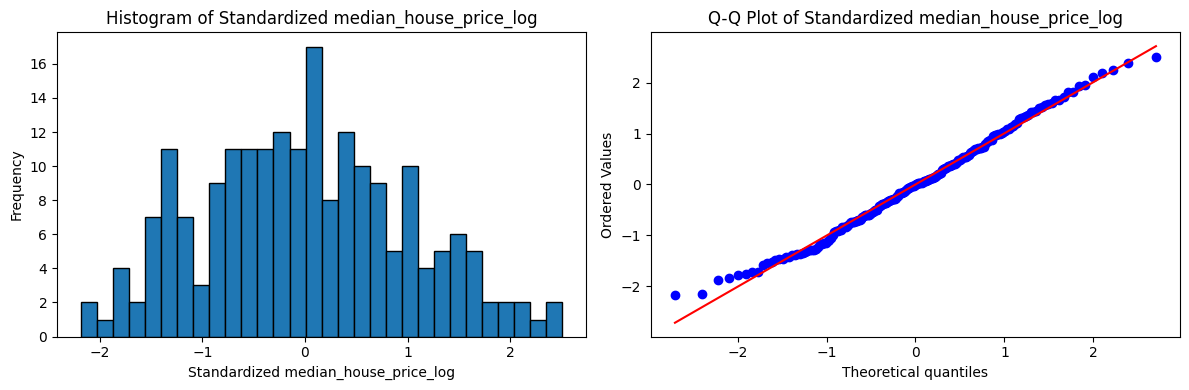

Kurtosis of median_house_price_log: -0.5012627795433828
Skewness of median_house_price_log: 0.17165776276638403
Shapiro-Wilk Test Statistic: 0.9907625914358906, p-value: 0.22416694143679172
The transformed data is normally distributed (fail to reject H0).


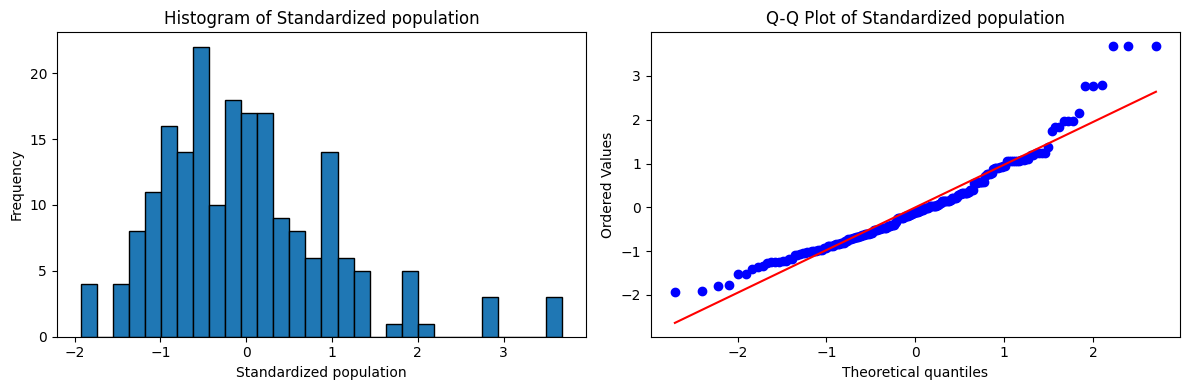

Kurtosis of population: 1.9082185055944292
Skewness of population: 1.0777853796795274
Shapiro-Wilk Test Statistic: 0.9371397351527715, p-value: 1.1539859703278438e-07
The transformed data is not normally distributed (reject H0).


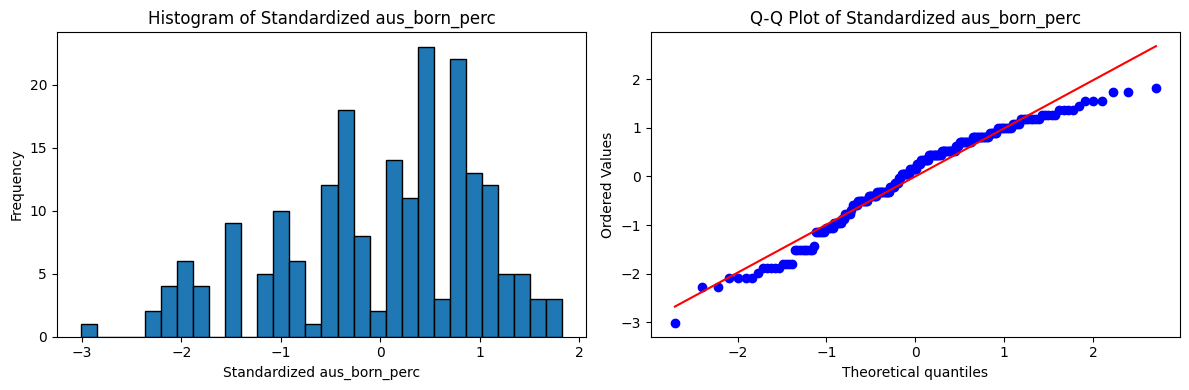

Kurtosis of aus_born_perc: -0.40492916539197976
Skewness of aus_born_perc: -0.563670002523909
Shapiro-Wilk Test Statistic: 0.9601284438702972, p-value: 1.856431406517858e-05
The transformed data is not normally distributed (reject H0).


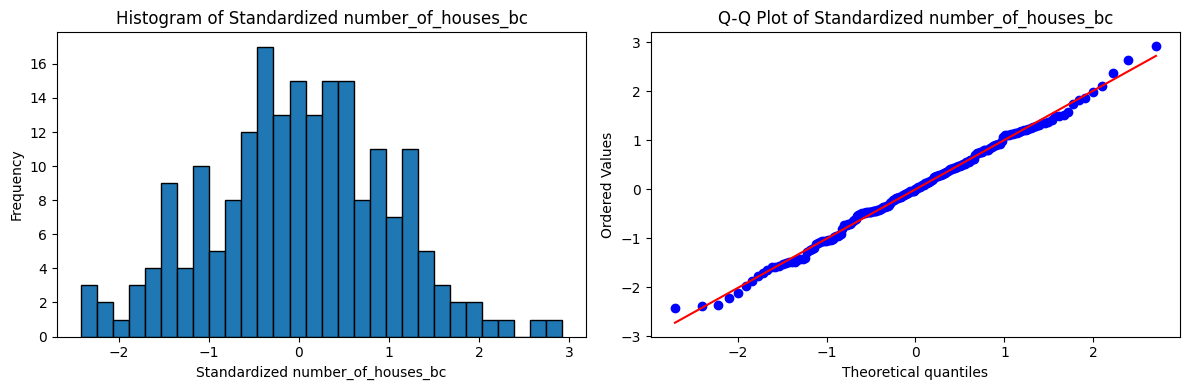

Kurtosis of number_of_houses_bc: -0.07374251261555775
Skewness of number_of_houses_bc: -0.0063579167705099734
Shapiro-Wilk Test Statistic: 0.9954566706600854, p-value: 0.8092981995076867
The transformed data is normally distributed (fail to reject H0).


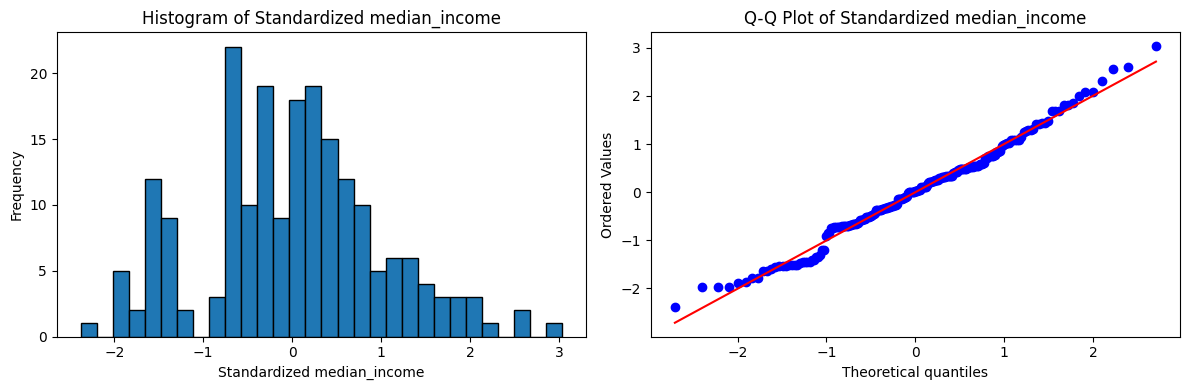

Kurtosis of median_income: 0.019242287904181588
Skewness of median_income: 0.17123435872628187
Shapiro-Wilk Test Statistic: 0.9883322491411486, p-value: 0.09751019125348462
The transformed data is normally distributed (fail to reject H0).


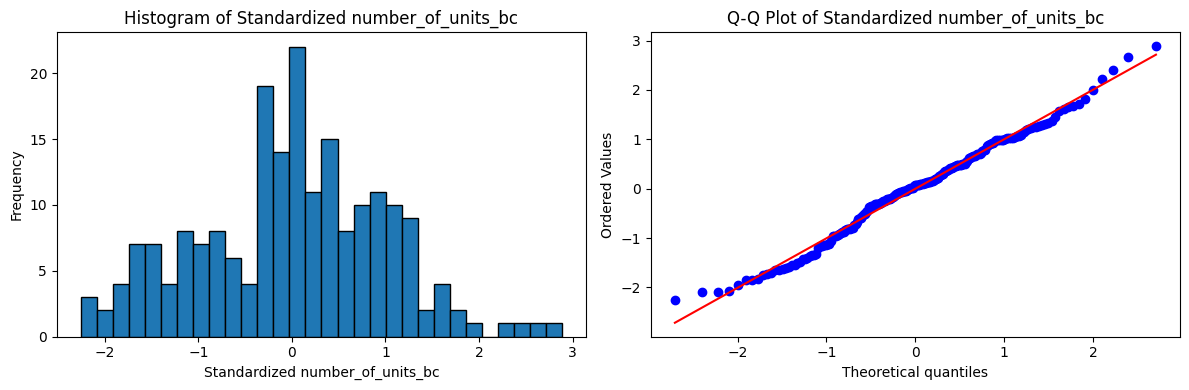

Kurtosis of number_of_units_bc: -0.19351985188043042
Skewness of number_of_units_bc: -0.014002383925762434
Shapiro-Wilk Test Statistic: 0.9894402406301278, p-value: 0.14317128735611706
The transformed data is normally distributed (fail to reject H0).


In [91]:
selected_features = ['median_house_price_log', 'population', 'aus_born_perc', 'number_of_houses_bc', 'median_income', 'number_of_units_bc']
for feature in selected_features:
  standardize_column(housing, feature)

In [92]:
housing.columns

Index(['suburb', 'number_of_houses', 'number_of_units', 'municipality',
       'aus_born_perc', 'median_income', 'median_house_price', 'population',
       'predicted_median_house_price', 'median_house_price_sqrt',
       'median_house_price_log', 'median_house_price_bc', 'population_sqrt',
       'population_log', 'population_bc', 'aus_born_perc_sqrt',
       'aus_born_perc_log', 'aus_born_perc_bc', 'number_of_houses_sqrt',
       'number_of_houses_log', 'number_of_houses_bc', 'number_of_units_sqrt',
       'number_of_units_log', 'number_of_units_bc', 'median_income_sqrt',
       'median_income_log', 'median_income_bc',
       'predicted_median_house_price_log',
       'median_house_price_log_standardized', 'population_bc_standardized',
       'aus_born_perc_bc_standardized', 'number_of_houses_bc_standardized',
       'number_of_units_bc_standardized', 'median_income_bc_standardized',
       'predicted_median_house_price_log_standardized',
       'population_standardized', 'aus_born_p

In [93]:
final_features = ['median_house_price_log_standardized', 'population_standardized', 'aus_born_perc_standardized', 'number_of_houses_bc_standardized', 'median_income_standardized', 'number_of_units_bc_standardized']

                                     OLS Regression Results                                    
Dep. Variable:     median_house_price_log_standardized   R-squared:                       0.686
Model:                                             OLS   Adj. R-squared:                  0.678
Method:                                  Least Squares   F-statistic:                     85.56
Date:                                 Fri, 18 Oct 2024   Prob (F-statistic):           2.27e-47
Time:                                         11:25:55   Log-Likelihood:                -169.20
No. Observations:                                  202   AIC:                             350.4
Df Residuals:                                      196   BIC:                             370.2
Df Model:                                            5                                         
Covariance Type:                             nonrobust                                         
                                       c

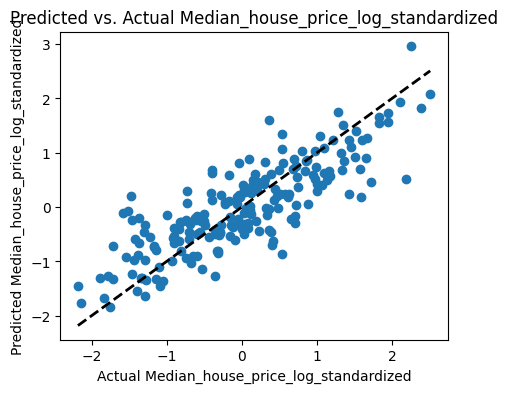

In [94]:
formula_final = 'median_house_price_log_standardized ~ population_standardized + aus_born_perc_standardized + number_of_houses_bc_standardized + median_income_standardized + number_of_units_bc_standardized'
model_final, df_final = calculate_regression_and_show(housing, formula_final)

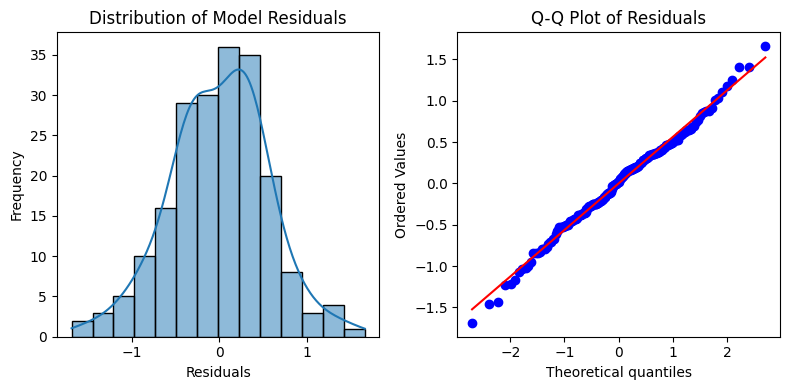

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.9943614260376155
P-value: 0.6473387745720128
The residuals are likely normally distributed (fail to reject H0).


In [95]:
graph_residuals('model_final', model_final, df_final)

The final linear regression and Shapiro Wilk test result are very similar to the original model8, except for coefficients since we just standardised all the features. But that is expected because standardisation is a linear transformation, so it changes only the values of coefficients but not statistics. After standartisation the coeffiecients are more comparable with each other and usually more convenient, but we neek inverse transformation to have explainable coefficients.

# Conclusion

After all the exploration, our recommendation for transformation is
1. Log transformation and then standradisation for 'median_house_price'
2. Standardisation for 'population'
3. Standardisation for 'aus_born_perc'
4. Boxcox transformation with default optimal lambda value or log transformation and then standradisation for 'number_of_houses'
5. Standardisation for 'median_income'
6. Boxcox transformation with default optimal lambda value or log transformation and then standradisation for 'number_of_units'


# Reference

1. pandas:
McKinney, W. (2010). Data Structures for Statistical Computing in Python. Proceedings of the 9th Python in Science Conference, 51-56. https://doi.org/10.25080/Majora-92bf1922-00a
2. Matplotlib:
Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90-95. https://doi.org/10.1109/MCSE.2007.55
3. re:
Python Software Foundation. (n.d.). re — Regular expression operations. Retrieved from https://docs.python.org/3/library/re.html
4. numpy:
Harris, C. R., Millman, K. J., van der Walt, S. J., et al. (2020). Array programming with NumPy. Nature, 585(7825), 357-362. https://doi.org/10.1038/s41586-020-2649-2
5. seaborn:
Waskom, M. L. (2021). Seaborn: Statistical Data Visualization. Journal of Open Source Software, 6(60), 3021. https://doi.org/10.21105/joss.03021
6. statsmodels:
Seabold, S., & Perktold, J. (2010). Statsmodels: Econometric and Statistical Modeling with Python. Proceedings of the 9th Python in Science Conference, 57-61. https://doi.org/10.25080/Majora-92bf1922-011
7. scipy:
Virtanen, P., Gommers, R., Oliphant, T. E., et al. (2020). SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods, 17, 261-272. https://doi.org/10.1038/s41592-019-0686-2
8. scikit-learn (RobustScaler):
Pedregosa, F., Varoquaux, G., Gramfort, A., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830. https://jmlr.org/papers/v12/pedregosa11a.html

We acknowledge the use of Gen-AI (ChatGPT, Copylot and Gemini) to get some hints about specific Python libraries/functions/classes/methods/options/settings. Every information from AI has been found and double-checked in the original library manuals.  
